In [103]:
import pandas as pd
df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\Em_Featured_MCR.csv")   
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__mcr_df_em_pre_New.csv")  
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_mcr_df_em_during_New.csv") 
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_mcr_df_em_post_New.csv")  


print("Shapes:", df_features.shape, df_pre.shape, df_during.shape, df_post.shape)

display(df_features.head(3))
display(df_pre.head(3))
display(df_during.head(3))
display(df_post.head(3))

Shapes: (1475, 47) (29, 3) (29, 3) (29, 3)


,overall_rating,review_date,verified_flag,travel_class,seat_comfort,staff_service,ground_service,value_for_money,recommended,food_quality,...,travel_type_missing,type_Business,type_Couple,type_Family,type_Solo,type_Unknown,food_quality_missing,wifi_missing,entertainment_missing,ground_service_missing
0,5.0,2023-12-31,2,1,2,5,3.0,2,0,4.0,...,0,False,True,False,False,False,0,0,0,0
1,1.0,2023-12-26,1,1,3,3,1.0,1,0,2.0,...,0,False,False,True,False,False,0,1,0,0
2,1.0,2023-12-25,2,1,1,1,3.0,1,0,1.0,...,0,False,False,False,True,False,0,0,0,0


,variable,MCR-,MCR+
0,verified_flag,0.018229,0.020023
1,travel_class,0.015451,0.018747
2,seat_comfort,0.271827,0.287638


,variable,MCR-,MCR+
0,verified_flag,0.000000,2.022930
1,travel_class,0.000031,4.420600
2,seat_comfort,0.000004,9.232875


,variable,MCR-,MCR+
0,verified_flag,7.346189e-08,0.725187
1,travel_class,1.179982e-06,2.378635
2,seat_comfort,3.937557e-05,9.329931


### Standardizing MCR Column Names  
- Ensures consistent column labels across pre-, during-, and post-COVID datasets.  
- Renames feature identifiers to `variable`.  
- Aligns MCR values to `MCR-` (lower bound) and `MCR+` (upper bound).  
- Prepares the datasets for merging and comparison.  

In [104]:
def standardize_mcr_cols(df):
    rename = {}
    for c in df.columns:
        cl = c.strip().lower()
        if "feature" in cl or "variable" in cl or "name" in cl:
            rename[c] = "variable"
        elif "mcr" in cl and ("-" in cl or "min" in cl or "lower" in cl):
            rename[c] = "MCR-"
        elif "mcr" in cl and ("+" in cl or "max" in cl or "upper" in cl):
            rename[c] = "MCR+"
    return df.rename(columns=rename)

df_pre    = standardize_mcr_cols(df_pre)
df_during = standardize_mcr_cols(df_during)
df_post   = standardize_mcr_cols(df_post)

print("Standardized columns (Emirates):")
print("pre   :", df_pre.columns.tolist())
print("during:", df_during.columns.tolist())
print("post  :", df_post.columns.tolist())

Standardized columns (Emirates):
pre   : ['variable', 'MCR-', 'MCR+']
during: ['variable', 'MCR-', 'MCR+']
post  : ['variable', 'MCR-', 'MCR+']


### Merging Periods and Computing Drift Metrics
Combined pre-, during-, and post-COVID MCR datasets into a single dataframe.  

In [106]:
import pandas as pd

# Load Emirates dataset directly
df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\Em_Featured_MCR.csv")


# Convert review_date to datetime
df_features["review_date"] = pd.to_datetime(df_features["review_date"])
# ==== Drop unwanted columns from Emirates features ====
df_features = df_features.drop(
    columns=[        # timestamp
        "sentiment_score",    # redundant with aspect sentiments
        "optimism", "joy", "anger",  # emotion overlap
        "sadness", "recommended", 
        "covid_period", "value_for_money"
    ],
    errors="ignore"  # <-- avoids crash if any col is missing
)



# Function to tag covid period
def assign_covid_period(date):
    if date < pd.Timestamp("2020-01-01"):
        return "pre"
    elif pd.Timestamp("2020-01-01") <= date <= pd.Timestamp("2021-12-31"):
        return "during"
    else:
        return "post"

# Apply covid period labeling
df_features["covid_period"] = df_features["review_date"].apply(assign_covid_period)

# Split into subsets
df_pre_data    = df_features[df_features["covid_period"] == "pre"]
df_during_data = df_features[df_features["covid_period"] == "during"]
df_post_data   = df_features[df_features["covid_period"] == "post"]

# Quick sanity check
print("All data:", df_features.shape)
print("Pre-COVID:", df_pre_data.shape)
print("During COVID:", df_during_data.shape)
print("Post-COVID:", df_post_data.shape)

All data: (1475, 41)
Pre-COVID: (1080, 41)
During COVID: (153, 41)
Post-COVID: (242, 41)


### Combining Periods and Identifying Top Drifting Features  
- Merged pre-, during-, and post-COVID MCR datasets into a single table.  
- Calculated drift magnitudes:  
  - `pre → during`  
  - `during → post`  
  - `total drift` across periods.  
- Assigned feature ranks within each period based on `MCR+` values.   
- Extracted top 10 features with the largest overall drift for closer inspection.  

In [107]:
import pandas as pd
import numpy as np

# ==== Combine Emirates pre/during/post MCRs ====
em_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# ==== Drift magnitudes (absolute differences in MCR+) ====
em_all["drift_pre_dur"]  = (em_all["MCR+_dur"]  - em_all["MCR+_pre"]).abs()
em_all["drift_dur_post"] = (em_all["MCR+_post"] - em_all["MCR+_dur"]).abs()
em_all["total_drift"]    = em_all["drift_pre_dur"] + em_all["drift_dur_post"]

# ==== Period-wise ranks (1 = most important) ====
em_all["rank_pre"]  = em_all["MCR+_pre"].rank(ascending=False, method="dense")
em_all["rank_dur"]  = em_all["MCR+_dur"].rank(ascending=False, method="dense")
em_all["rank_post"] = em_all["MCR+_post"].rank(ascending=False, method="dense")

# ==== Rank changes (positive = moved DOWN, negative = moved UP) ====
em_all["rank_change_pre_to_dur"]  = em_all["rank_dur"]  - em_all["rank_pre"]
em_all["rank_change_dur_to_post"] = em_all["rank_post"] - em_all["rank_dur"]

# ==== Top 10 drifting features ====
top_drift_em = em_all.sort_values("total_drift", ascending=False).head(10)

# Show clean summary
top_drift_em = top_drift_em[
    ["variable","MCR+_pre","MCR+_dur","MCR+_post","total_drift","rank_pre","rank_dur","rank_post"]
]

print("Top 10 drifting features (Emirates):")
display(top_drift_em)

Top 10 drifting features (Emirates):


,variable,MCR+_pre,MCR+_dur,MCR+_post,total_drift,rank_pre,rank_dur,rank_post
15,entertainment_sentiment,0.256469,12.946876,7.554947,18.082336,9.0,3.0,9.0
10,seat_sentiment,0.649740,14.174872,11.098056,16.601948,3.0,2.0,2.0
11,staff_sentiment,0.592821,15.829949,15.179238,15.887840,4.0,1.0,1.0
13,refunds_sentiment,0.230608,8.783448,4.228309,13.107980,10.0,9.0,14.0
4,ground_service,1.184108,11.386309,9.128476,12.460033,1.0,4.0,5.0
3,staff_service,1.020604,11.351291,9.995768,11.686209,2.0,5.0,3.0
14,lounge_sentiment,0.118121,9.347615,6.930943,11.646166,15.0,7.0,11.0
25,food_quality_missing,0.011331,6.623272,1.899690,11.335523,26.0,13.0,25.0
22,topic_meals_food,0.080882,6.541702,2.948759,10.053763,20.0,15.0,20.0
23,topic_baggage,0.130419,7.041197,4.187728,9.764247,14.0,12.0,15.0


### Ranking and Selecting Top Features by Period  

In [108]:
# ==== Rank Emirates features within each period ====
df_pre["rank_pre"]       = df_pre["MCR+"].rank(ascending=False, method="dense")
df_during["rank_during"] = df_during["MCR+"].rank(ascending=False, method="dense")
df_post["rank_post"]     = df_post["MCR+"].rank(ascending=False, method="dense")

# ==== Sort and select Top 10 per period ====
top_pre_em    = df_pre.sort_values("rank_pre").head(10)[["variable","MCR+","rank_pre"]]
top_during_em = df_during.sort_values("rank_during").head(10)[["variable","MCR+","rank_during"]]
top_post_em   = df_post.sort_values("rank_post").head(10)[["variable","MCR+","rank_post"]]

print("=== Top 10 Pre-COVID (Emirates) ===")
display(top_pre_em)

print("=== Top 10 During-COVID (Emirates) ===")
display(top_during_em)

print("=== Top 10 Post-COVID (Emirates) ===")
display(top_post_em)


=== Top 10 Pre-COVID (Emirates) ===


,variable,MCR+,rank_pre
4,ground_service,1.184108,1.0
3,staff_service,1.020604,2.0
10,seat_sentiment,0.649740,3.0
11,staff_sentiment,0.592821,4.0
5,food_quality,0.474889,5.0
6,entertainment_score,0.346181,6.0
9,food_sentiment,0.299706,7.0
2,seat_comfort,0.287638,8.0
15,entertainment_sentiment,0.256469,9.0
13,refunds_sentiment,0.230608,10.0


=== Top 10 During-COVID (Emirates) ===


,variable,MCR+,rank_during
11,staff_sentiment,15.829949,1.0
10,seat_sentiment,14.174872,2.0
15,entertainment_sentiment,12.946876,3.0
4,ground_service,11.386309,4.0
3,staff_service,11.351291,5.0
9,food_sentiment,9.497707,6.0
14,lounge_sentiment,9.347615,7.0
2,seat_comfort,9.232875,8.0
13,refunds_sentiment,8.783448,9.0
5,food_quality,8.707938,10.0


=== Top 10 Post-COVID (Emirates) ===


,variable,MCR+,rank_post
11,staff_sentiment,15.179238,1.0
10,seat_sentiment,11.098056,2.0
3,staff_service,9.995768,3.0
2,seat_comfort,9.329931,4.0
4,ground_service,9.128476,5.0
17,airport_service_sentiment,9.012013,6.0
9,food_sentiment,9.005324,7.0
5,food_quality,7.879942,8.0
15,entertainment_sentiment,7.554947,9.0
6,entertainment_score,7.518493,10.0


### Computing Drift and Concept Drift Index (CDI)  

- **Merged pre-, during-, and post-COVID MCR values** into a single table for feature-level comparison.  
- Calculated multiple drift indicators:  
  1. **Drift Magnitude (Δᵢ):** Absolute total change in `MCR+` across periods.  
  2. **Volatility Index (Vᵢ):** Maximum width of the feature’s reliance interval `[MCR−, MCR+]` across periods.  
  3. **Rank Drift (Rᵢ):** Maximum change in feature importance rank across periods.  
- Derived a **system-level Concept Drift Index (CDI):** the mean drift magnitude across all features, summarizing overall drift intensity.  
- Identified the **Top 10 features with the highest drift** for closer inspection.

In [109]:
import pandas as pd

# ==== Merge all Emirates periods into one table ====
em_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# --------------------
# 1. Drift Magnitude Δ_i
# --------------------
em_all["drift_total"] = (
    (em_all["MCR+_pre"] - em_all["MCR+_dur"]).abs()
    + (em_all["MCR+_dur"] - em_all["MCR+_post"]).abs()
)

# --------------------
# 2. Volatility Index V_i (max width of [MCR-, MCR+])
# --------------------
em_all["range_pre"]  = em_all["MCR+_pre"]  - em_all["MCR-_pre"]
em_all["range_dur"]  = em_all["MCR+_dur"]  - em_all["MCR-_dur"]
em_all["range_post"] = em_all["MCR+_post"] - em_all["MCR-_post"]
em_all["volatility"] = em_all[["range_pre","range_dur","range_post"]].max(axis=1)

# --------------------
# 3. Rank Drift R_i
# --------------------
em_all["rank_pre"]  = em_all["MCR+_pre"].rank(ascending=False, method="dense")
em_all["rank_dur"]  = em_all["MCR+_dur"].rank(ascending=False, method="dense")
em_all["rank_post"] = em_all["MCR+_post"].rank(ascending=False, method="dense")

em_all["rank_drift"] = em_all.apply(
    lambda row: max(abs(row["rank_pre"]-row["rank_dur"]),
                    abs(row["rank_dur"]-row["rank_post"])),
    axis=1
)

# --------------------
# 4. System-Level Concept Drift Index (CDI)
# --------------------
CDI_em = em_all["drift_total"].mean()
print(f"Concept Drift Index (CDI) for Emirates = {CDI_em:.3f}")

# --------------------
# Show top drifting features
# --------------------
top_drift_em = em_all.sort_values("drift_total", ascending=False)[
    ["variable","MCR+_pre","MCR+_dur","MCR+_post",
     "drift_total","volatility","rank_pre","rank_dur","rank_post","rank_drift"]
].head(10)

display(top_drift_em)

Concept Drift Index (CDI) for Emirates = 8.675


,variable,MCR+_pre,MCR+_dur,MCR+_post,drift_total,volatility,rank_pre,rank_dur,rank_post,rank_drift
15,entertainment_sentiment,0.256469,12.946876,7.554947,18.082336,12.946842,9.0,3.0,9.0,6.0
10,seat_sentiment,0.649740,14.174872,11.098056,16.601948,14.170327,3.0,2.0,2.0,1.0
11,staff_sentiment,0.592821,15.829949,15.179238,15.887840,15.829927,4.0,1.0,1.0,3.0
13,refunds_sentiment,0.230608,8.783448,4.228309,13.107980,8.783446,10.0,9.0,14.0,5.0
4,ground_service,1.184108,11.386309,9.128476,12.460033,11.386263,1.0,4.0,5.0,3.0
3,staff_service,1.020604,11.351291,9.995768,11.686209,11.351260,2.0,5.0,3.0,3.0
14,lounge_sentiment,0.118121,9.347615,6.930943,11.646166,9.347610,15.0,7.0,11.0,8.0
25,food_quality_missing,0.011331,6.623272,1.899690,11.335523,6.623272,26.0,13.0,25.0,13.0
22,topic_meals_food,0.080882,6.541702,2.948759,10.053763,6.541696,20.0,15.0,20.0,5.0
23,topic_baggage,0.130419,7.041197,4.187728,9.764247,7.041192,14.0,12.0,15.0,3.0


# MCR top features per period

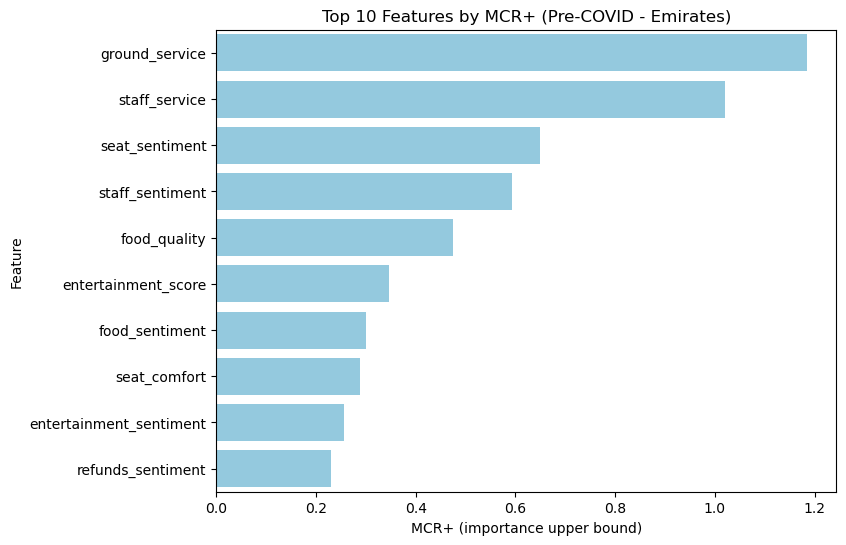

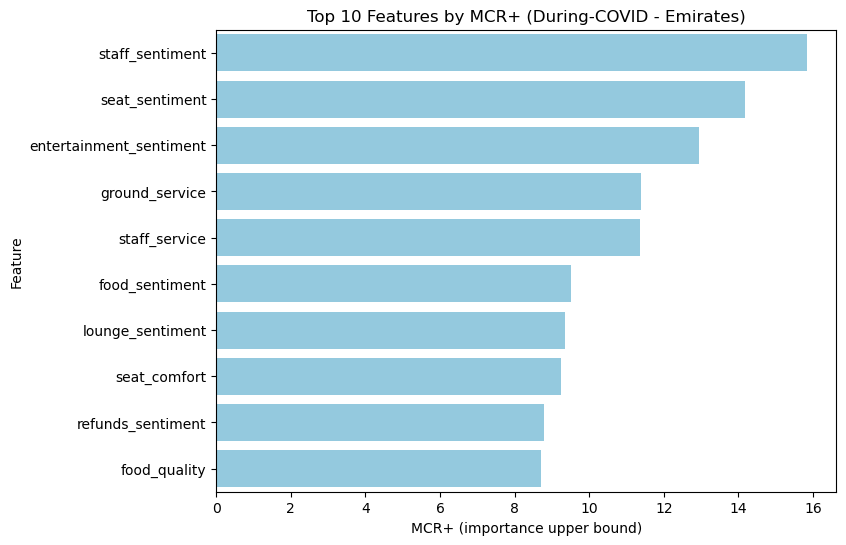

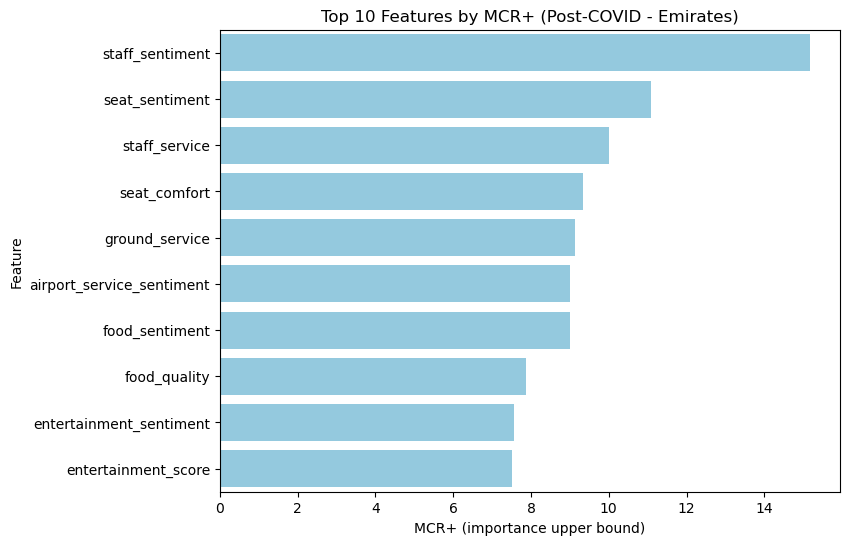

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importance(df, mcr_col, rank_col, title):
    df_sorted = df.sort_values(rank_col).head(10)
    plt.figure(figsize=(8,6))
    sns.barplot(x=mcr_col, y="variable", data=df_sorted, color="skyblue")
    plt.title(f"Top 10 Features by {mcr_col} ({title} - Emirates)")
    plt.xlabel("MCR+ (importance upper bound)")
    plt.ylabel("Feature")
    plt.show()

plot_importance(df_pre, "MCR+", "rank_pre", "Pre-COVID")
plot_importance(df_during, "MCR+", "rank_during", "During-COVID")
plot_importance(df_post, "MCR+", "rank_post", "Post-COVID")

## Heatmap Ranking Across Periods

Concept Drift Index (CDI) for Emirates = 8.675


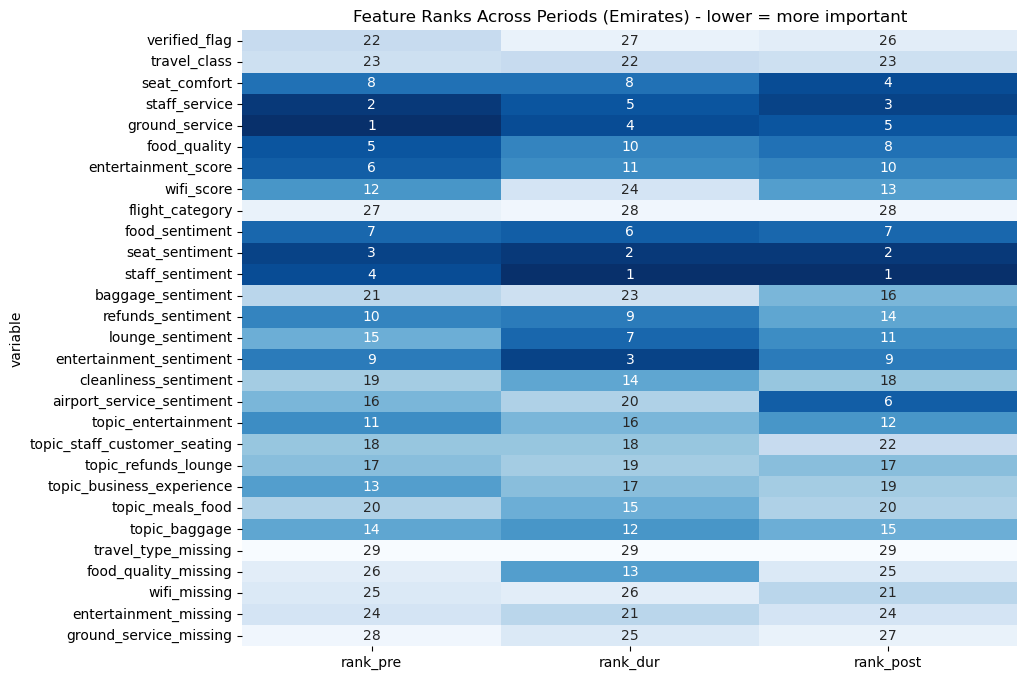

In [111]:
CDI_em = em_all["drift_total"].mean()
print(f"Concept Drift Index (CDI) for Emirates = {CDI_em:.3f}")

rank_table_em = (
    em_all[["variable","rank_pre","rank_dur","rank_post"]]
    .set_index("variable")
)

plt.figure(figsize=(10,8))
sns.heatmap(rank_table_em, annot=True, cmap="Blues_r", cbar=False)
plt.title("Feature Ranks Across Periods (Emirates) - lower = more important")
plt.show()

### Top 5 Feature Trajectory MCR+ values across periods

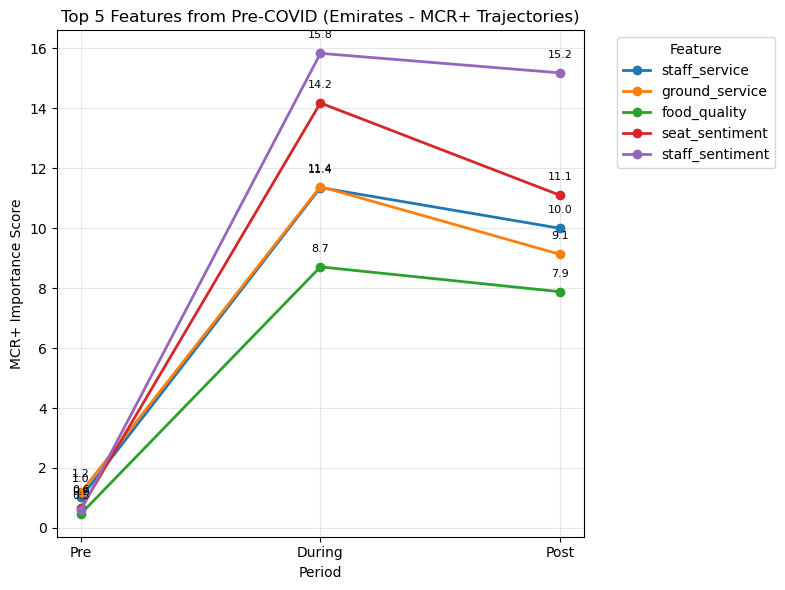

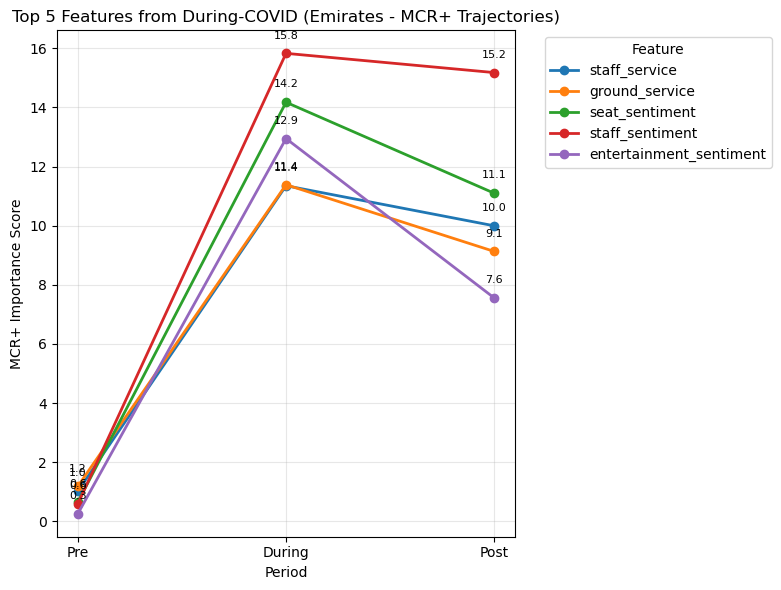

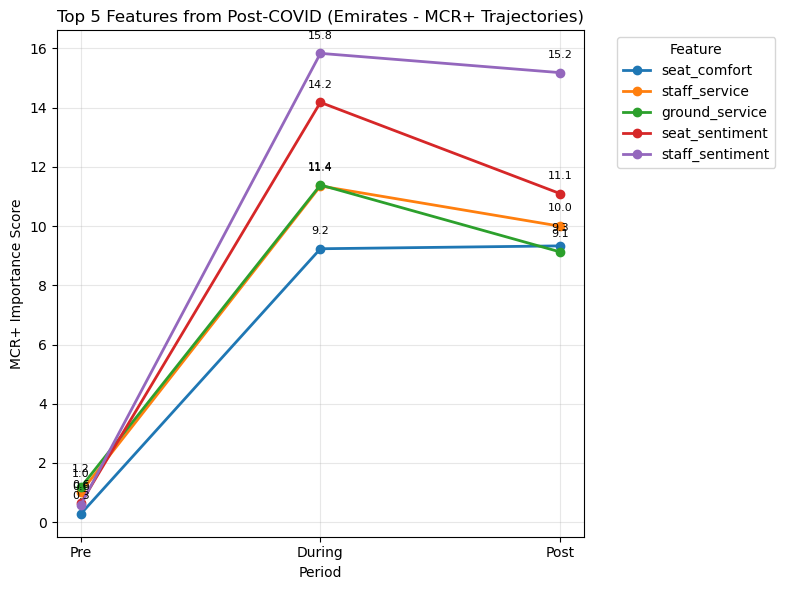

In [25]:
def plot_top5_trajectories(df_period, period_name, df_all):
    # Get top 5 features for this period
    top5 = df_period.nlargest(5, "MCR+")["variable"].tolist()
    subset = df_all[df_all["variable"].isin(top5)]

    # Plot
    plt.figure(figsize=(8,6))
    for _, row in subset.iterrows():
        ys = [row["MCR+_pre"], row["MCR+_dur"], row["MCR+_post"]]
        plt.plot(["Pre","During","Post"], ys, marker="o", linewidth=2, label=row["variable"])
        for i, val in enumerate(ys):
            plt.text(i, val+0.5, f"{val:.1f}", ha="center", fontsize=8)

    plt.title(f"Top 5 Features from {period_name} (Emirates - MCR+ Trajectories)")
    plt.ylabel("MCR+ Importance Score")
    plt.xlabel("Period")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run for Pre, During, Post (Emirates)
plot_top5_trajectories(df_pre, "Pre-COVID", em_all)
plot_top5_trajectories(df_during, "During-COVID", em_all)
plot_top5_trajectories(df_post, "Post-COVID", em_all)

### Top 5 Feature Trajectory MCR+ values across periods [Normalised]

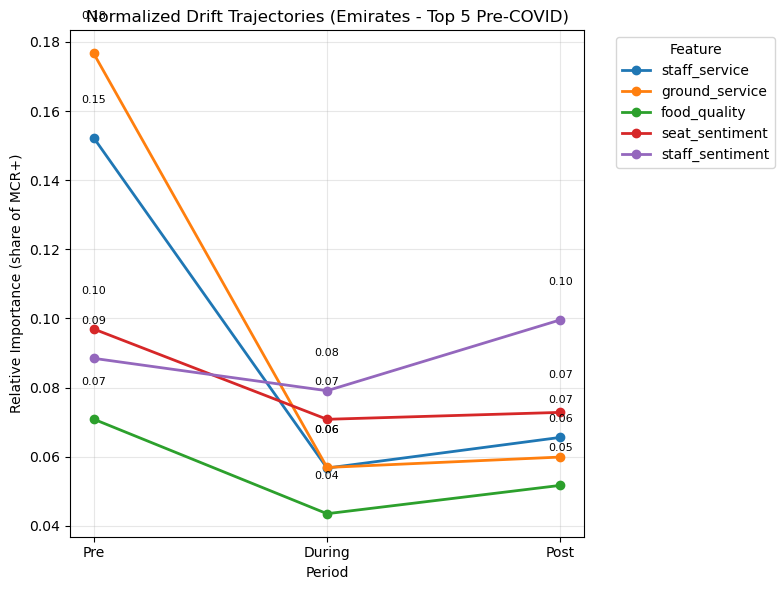

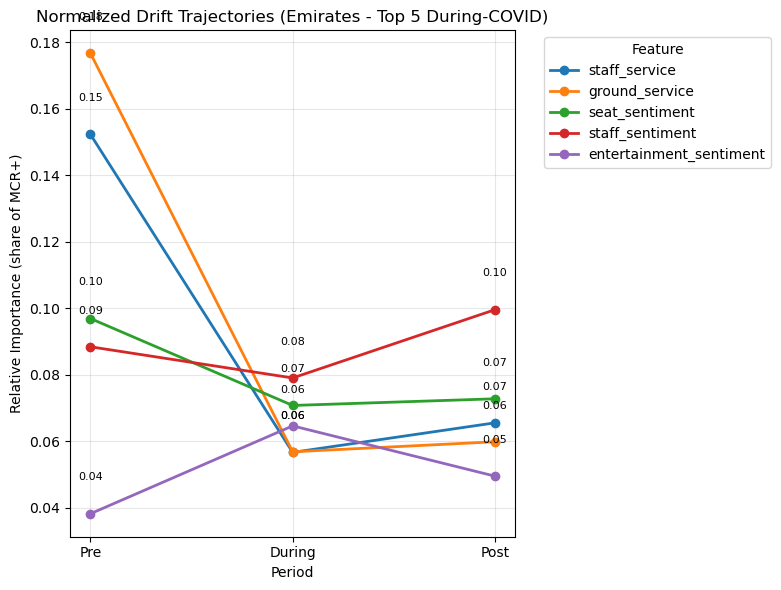

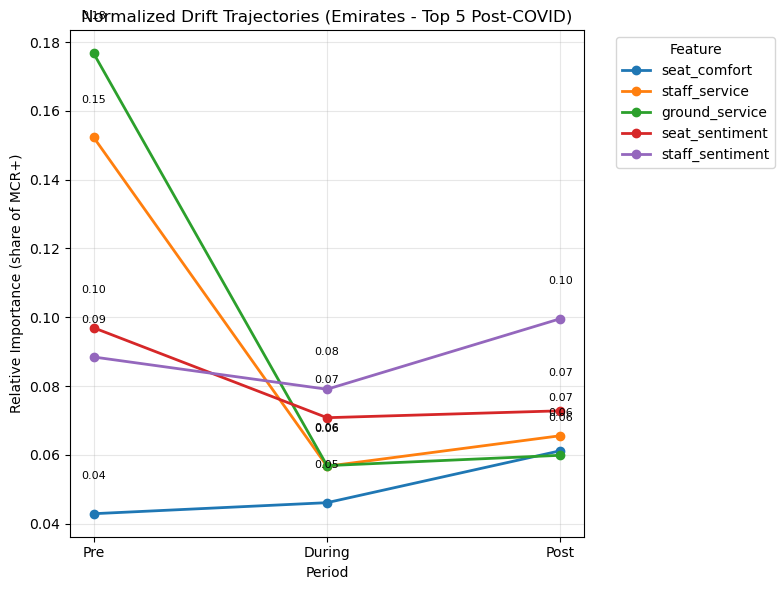

In [26]:
# ==== Make a copy to avoid overwriting ====
em_norm = em_all.copy()

# Normalize MCR+ scores within each period
for col in ["MCR+_pre", "MCR+_dur", "MCR+_post"]:
    em_norm[col] = em_norm[col] / em_norm[col].sum()

# === Plot normalized trajectories for top features per period (Emirates) ===
def plot_top5_norm(df_period, period_name, df_all):
    # Get top 5 features by raw MCR+ in this period
    top5 = df_period.nlargest(5, "MCR+")["variable"].tolist()
    subset = df_all[df_all["variable"].isin(top5)]

    # Plot
    plt.figure(figsize=(8,6))
    for _, row in subset.iterrows():
        ys = [row["MCR+_pre"], row["MCR+_dur"], row["MCR+_post"]]
        plt.plot(["Pre","During","Post"], ys, marker="o", linewidth=2, label=row["variable"])
        for i, val in enumerate(ys):
            plt.text(i, val+0.01, f"{val:.2f}", ha="center", fontsize=8)

    plt.title(f"Normalized Drift Trajectories (Emirates - Top 5 {period_name})")
    plt.ylabel("Relative Importance (share of MCR+)")
    plt.xlabel("Period")
    plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run for Pre, During, Post (Emirates)
plot_top5_norm(df_pre, "Pre-COVID", em_norm)
plot_top5_norm(df_during, "During-COVID", em_norm)
plot_top5_norm(df_post, "Post-COVID", em_norm)


### Slope chart for Commparison of Ranks

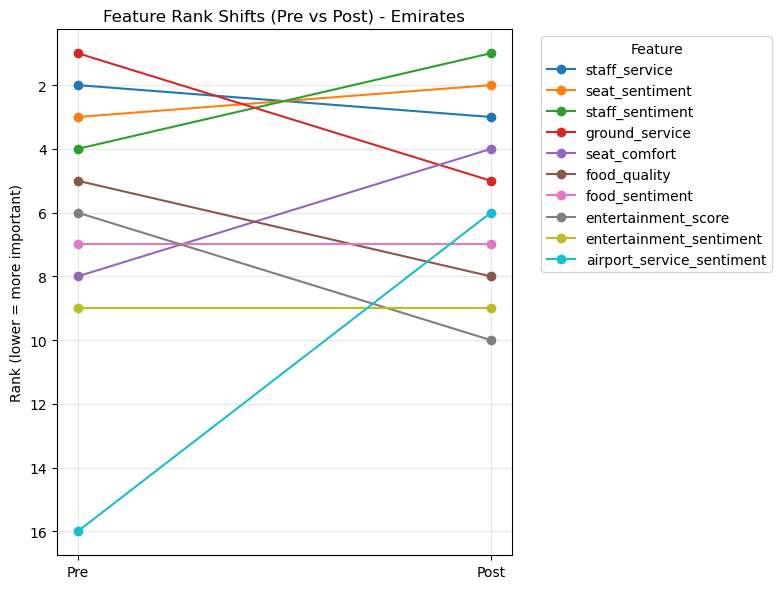

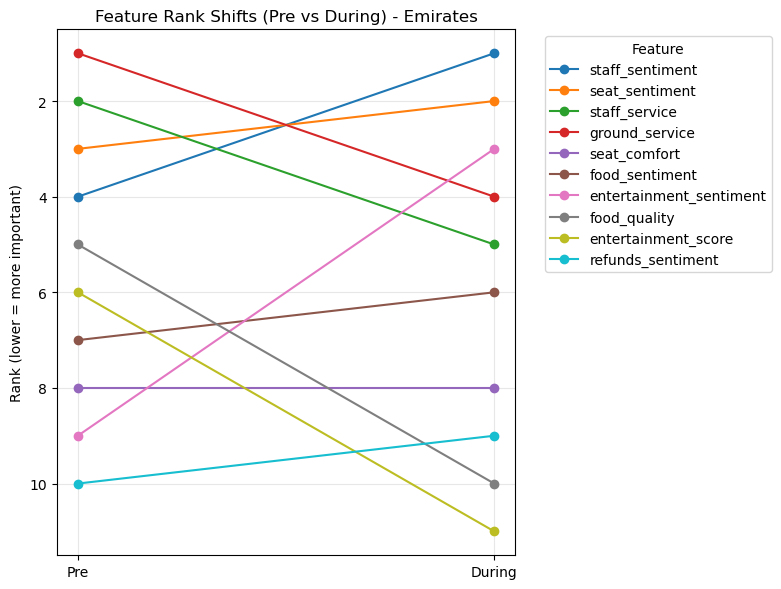

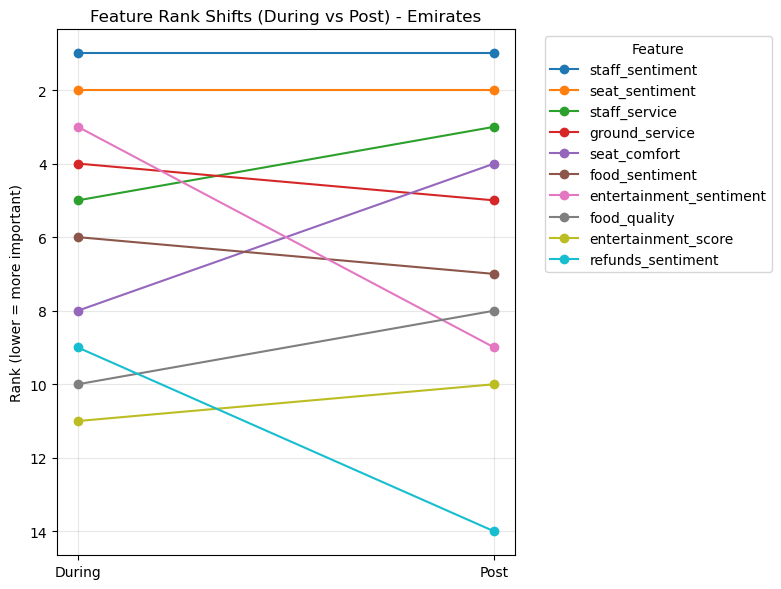

In [101]:
# ==== Get top N (say 10) features by average rank (Emirates) ====
topN_em = em_all.copy()
topN_em["avg_rank"] = topN_em[["rank_pre","rank_post"]].mean(axis=1)
topN_em = topN_em.nsmallest(10,"avg_rank")

# ==== Create slope chart data ====
df_slope_em = topN_em.melt(
    id_vars="variable",
    value_vars=["rank_pre","rank_post"],
    var_name="period",
    value_name="rank"
)

# ==== Plot slope chart ====
plt.figure(figsize=(8,6))
for var in df_slope_em["variable"].unique():
    sub = df_slope_em[df_slope_em["variable"]==var]
    plt.plot(["Pre","Post"], sub["rank"], marker="o", label=var)

plt.gca().invert_yaxis()  # lower rank = more important
plt.title("Feature Rank Shifts (Pre vs Post) - Emirates")
plt.ylabel("Rank (lower = more important)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==== Get top N (say 10) features by average rank (Emirates) ====
topN_em = em_all.copy()
topN_em["avg_rank"] = em_all[["rank_pre","rank_dur","rank_post"]].mean(axis=1)
topN_em = topN_em.nsmallest(10,"avg_rank")


# ==== Pre vs During ====
df_slope_em_pre_dur = topN_em.melt(
    id_vars="variable",
    value_vars=["rank_pre","rank_dur"],
    var_name="period",
    value_name="rank"
)

plt.figure(figsize=(8,6))
for var in df_slope_em_pre_dur["variable"].unique():
    sub = df_slope_em_pre_dur[df_slope_em_pre_dur["variable"]==var]
    plt.plot(["Pre","During"], sub["rank"], marker="o", label=var)

plt.gca().invert_yaxis()
plt.title("Feature Rank Shifts (Pre vs During) - Emirates")
plt.ylabel("Rank (lower = more important)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ==== During vs Post ====
df_slope_em_dur_post = topN_em.melt(
    id_vars="variable",
    value_vars=["rank_dur","rank_post"],
    var_name="period",
    value_name="rank"
)

plt.figure(figsize=(8,6))
for var in df_slope_em_dur_post["variable"].unique():
    sub = df_slope_em_dur_post[df_slope_em_dur_post["variable"]==var]
    plt.plot(["During","Post"], sub["rank"], marker="o", label=var)

plt.gca().invert_yaxis()
plt.title("Feature Rank Shifts (During vs Post) - Emirates")
plt.ylabel("Rank (lower = more important)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

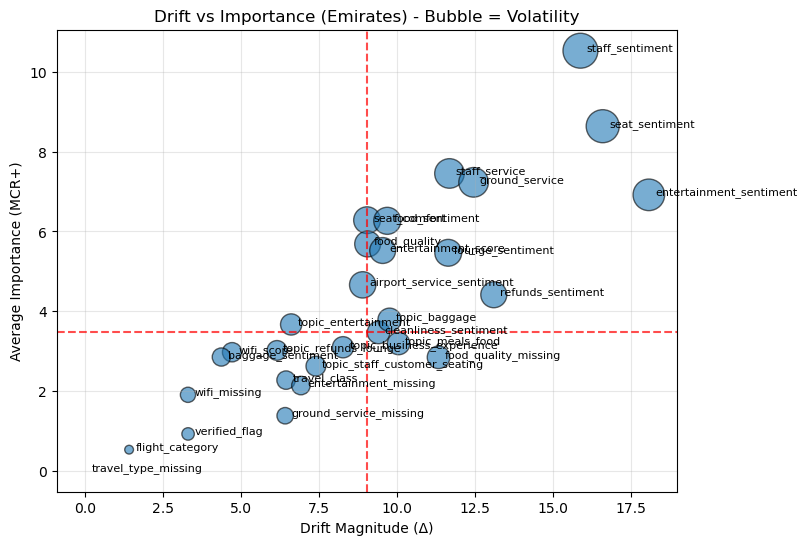

In [28]:
# ==== Make sure avg_importance is created (Emirates) ====
em_all["avg_importance"] = em_all[["MCR+_pre", "MCR+_dur", "MCR+_post"]].mean(axis=1)

plt.figure(figsize=(8,6))

x = em_all["drift_total"]
y = em_all["avg_importance"]
s = em_all["volatility"] * 40  # bubble size

plt.scatter(x, y, s=s, alpha=0.6, edgecolor="k")

# Annotate features
for i, row in em_all.iterrows():
    plt.text(row["drift_total"]+0.2, row["avg_importance"], row["variable"], fontsize=8)

# Add quadrant lines (using medians)
plt.axvline(x.median(), color="red", linestyle="--", alpha=0.7)
plt.axhline(y.median(), color="red", linestyle="--", alpha=0.7)

plt.xlabel("Drift Magnitude (Δ)")
plt.ylabel("Average Importance (MCR+)")
plt.title("Drift vs Importance (Emirates) - Bubble = Volatility")
plt.grid(alpha=0.3)
plt.show()

### Radar Plot: Category-Level Drift in Feature Reliance  

- Grouped individual features into **three broad categories**:  
  - **Service** (e.g., seat comfort, staff service, wifi, food quality).  
  - **Sentiment** (e.g., sentiment scores across food, seat, staff, baggage, etc.).  
  - **Topics** (all topic_* variables).

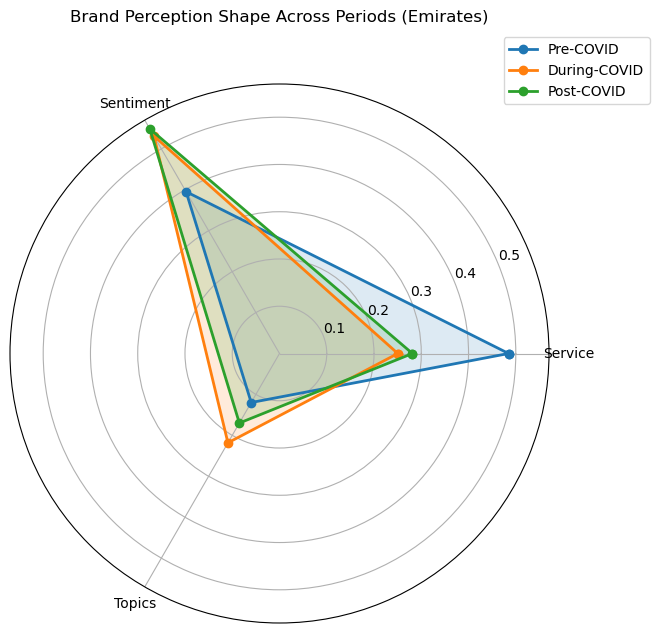

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Define categories (Emirates) ====
categories = {
    "Service": ["seat_comfort","staff_service","ground_service","value_for_money",
                "food_quality","entertainment","wifi"],
    "Sentiment": ["sentiment_score","food_sentiment","seat_sentiment","staff_sentiment",
                  "baggage_sentiment","refunds_sentiment","lounge_sentiment",
                  "entertainment_sentiment","cleanliness_sentiment","airport_service_sentiment"],
    "Topics": [c for c in em_all["variable"] if c.startswith("topic_")]
}

# ==== Function: aggregate importance by category (normalized) ====
def get_category_values(period_col):
    values = []
    for cat, feats in categories.items():
        vals = em_all.loc[em_all["variable"].isin(feats), period_col].sum()
        values.append(vals)
    # normalize to sum=1
    values = np.array(values) / np.sum(values)
    values = list(values) + [values[0]]  # close loop
    return values

# Labels & angles
labels = list(categories.keys())
angles = np.linspace(0, 2*np.pi, len(labels)+1, endpoint=True)

# Values for each period
vals_pre = get_category_values("MCR+_pre")
vals_dur = get_category_values("MCR+_dur")
vals_post = get_category_values("MCR+_post")

# ==== Plot ====
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, vals_pre, "o-", linewidth=2, label="Pre-COVID")
ax.fill(angles, vals_pre, alpha=0.15)

ax.plot(angles, vals_dur, "o-", linewidth=2, label="During-COVID")
ax.fill(angles, vals_dur, alpha=0.15)

ax.plot(angles, vals_post, "o-", linewidth=2, label="Post-COVID")
ax.fill(angles, vals_post, alpha=0.15)

ax.set_thetagrids(angles[:-1]*180/np.pi, labels)
ax.set_title("Brand Perception Shape Across Periods (Emirates)", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.show()


## Structure of Reliance shifted categories over time Pie Chart

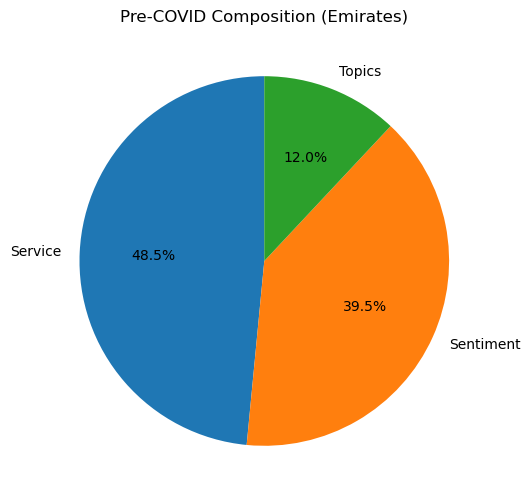

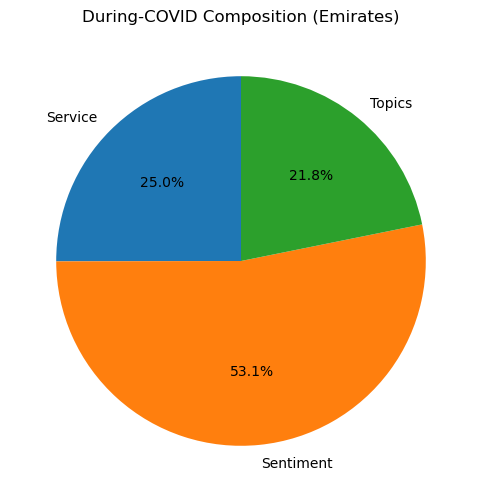

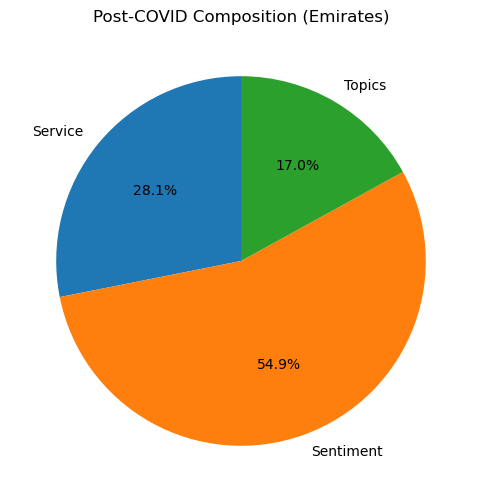

In [30]:
import matplotlib.pyplot as plt

# ==== Define feature groups (Emirates) ====
categories = {
    "Service": ["seat_comfort","staff_service","ground_service","value_for_money",
                "food_quality","entertainment","wifi"],
    "Sentiment": ["sentiment_score","food_sentiment","seat_sentiment","staff_sentiment",
                  "baggage_sentiment","refunds_sentiment","lounge_sentiment",
                  "entertainment_sentiment","cleanliness_sentiment","airport_service_sentiment"],
    "Topics": [c for c in em_all["variable"] if c.startswith("topic_")]
}

# ==== Function to plot pie chart by period (Emirates) ====
def pie_chart(period_col, title):
    data = []
    labels = []
    for cat, feats in categories.items():
        val = em_all.loc[em_all["variable"].isin(feats), period_col].sum()
        data.append(val)
        labels.append(cat)
    plt.figure(figsize=(6,6))
    plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f"{title} (Emirates)")
    plt.show()

# ==== Run for each period ====
pie_chart("MCR+_pre", "Pre-COVID Composition")
pie_chart("MCR+_dur", "During-COVID Composition")
pie_chart("MCR+_post", "Post-COVID Composition")

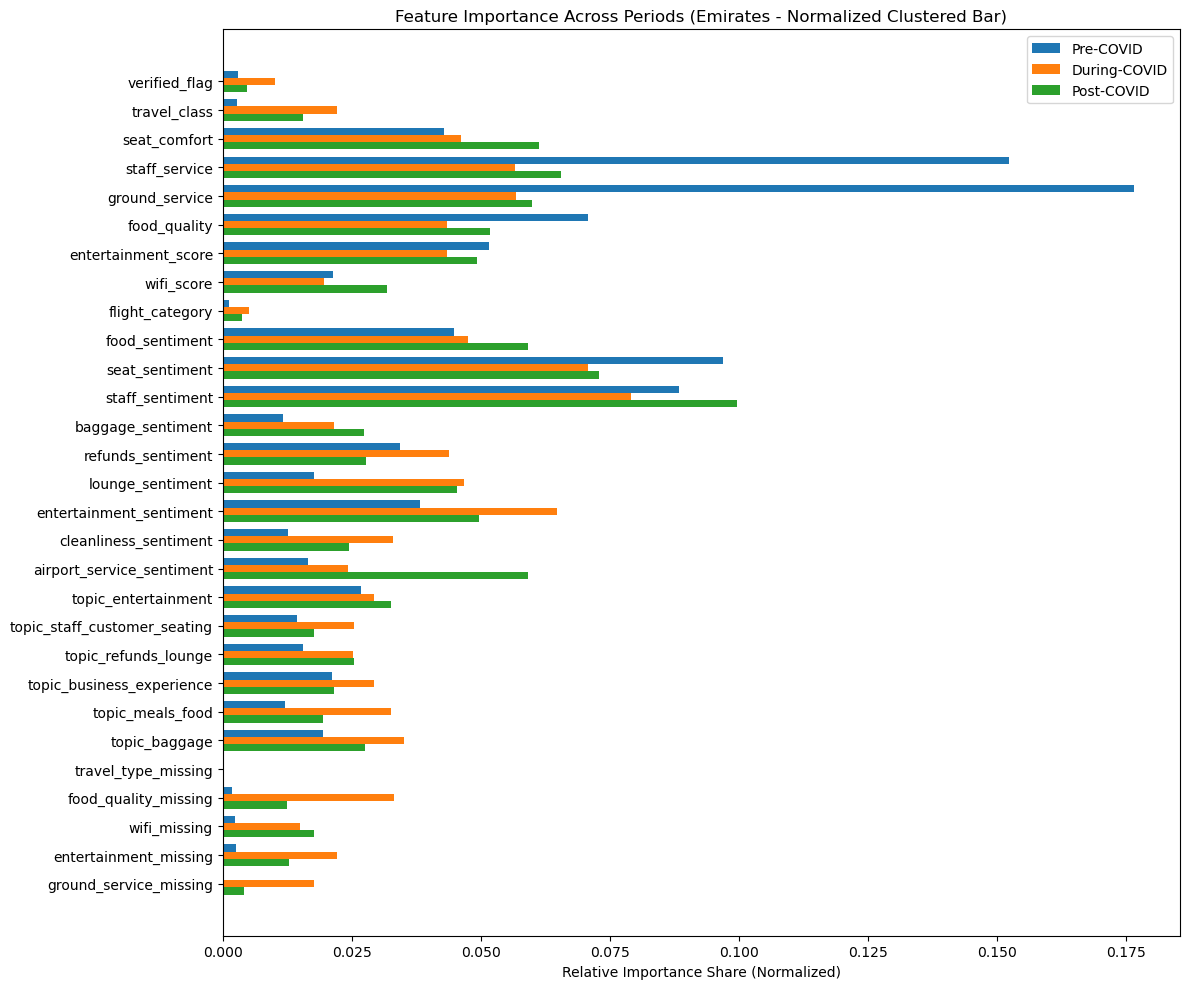

In [31]:
# ==== Normalize MCR+ within each period (each period sums to 1) ====
em_sorted = em_all.copy()
for col in ["MCR+_pre", "MCR+_dur", "MCR+_post"]:
    em_sorted[col+"_norm"] = em_sorted[col] / em_sorted[col].sum()

# ==== Plot normalized clustered bar chart (Emirates) ====
plt.figure(figsize=(12,10))
x = np.arange(len(em_sorted))

width = 0.25
plt.barh(x - width, em_sorted["MCR+_pre_norm"], height=width, label="Pre-COVID")
plt.barh(x,         em_sorted["MCR+_dur_norm"], height=width, label="During-COVID")
plt.barh(x + width, em_sorted["MCR+_post_norm"], height=width, label="Post-COVID")

plt.yticks(x, em_sorted["variable"])
plt.xlabel("Relative Importance Share (Normalized)")
plt.title("Feature Importance Across Periods (Emirates - Normalized Clustered Bar)")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


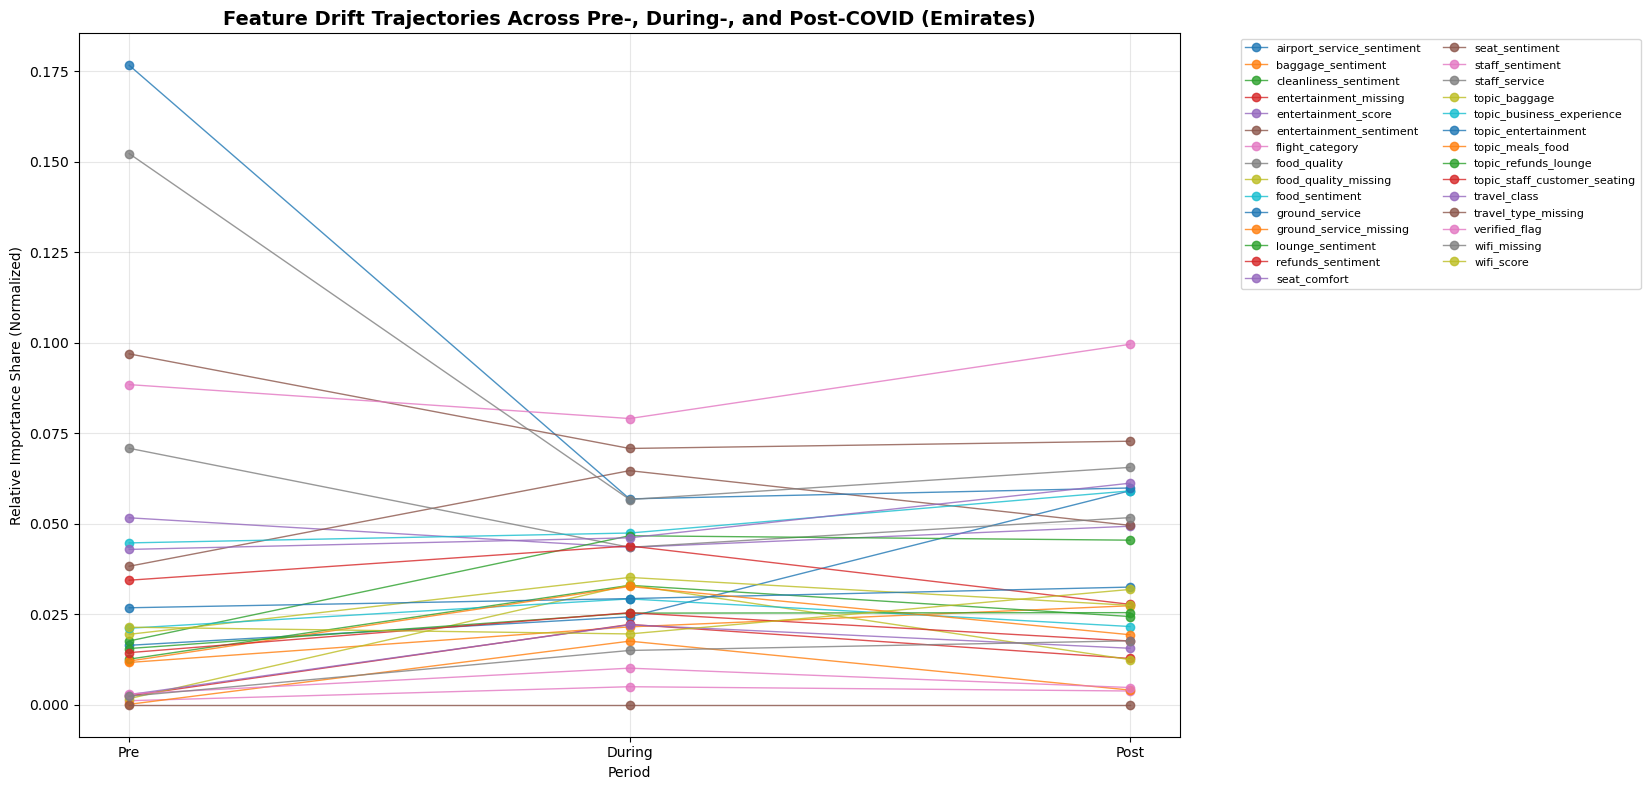

In [34]:
# Melt Emirates normalized data into long format
df_long_em = em_sorted.melt(
    id_vars="variable",
    value_vars=["MCR+_pre_norm","MCR+_dur_norm","MCR+_post_norm"],
    var_name="Period",
    value_name="Importance"
)

# Clean up period labels
df_long_em["Period"] = df_long_em["Period"].str.replace("MCR+_", "").str.replace("_norm","")
df_long_em["Period"] = df_long_em["Period"].map({"pre":"Pre","dur":"During","post":"Post"})

# === Plot drift trajectories (Emirates) ===
plt.figure(figsize=(12,8))

for var, sub in df_long_em.groupby("variable"):
    plt.plot(sub["Period"], sub["Importance"], marker="o", linewidth=1, alpha=0.8, label=var)

plt.title("Feature Drift Trajectories Across Pre-, During-, and Post-COVID (Emirates)", fontsize=14, weight="bold")
plt.ylabel("Relative Importance Share (Normalized)")
plt.xlabel("Period")
plt.grid(alpha=0.3)
plt.tight_layout()

# Legend with compact layout
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2, fontsize=8)
plt.show()


In [35]:
import pandas as pd

# --- Merge Emirates periods ---
em_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# --- Normalize MCR+ per period (relative importance) ---
for col in ["MCR+_pre", "MCR+_dur", "MCR+_post"]:
    em_all[col+"_norm"] = em_all[col] / em_all[col].sum()

# --------------------
# 1. Drift Magnitude Δ_i (on normalized)
# --------------------
em_all["drift_total"] = (
    (em_all["MCR+_pre_norm"] - em_all["MCR+_dur_norm"]).abs()
    + (em_all["MCR+_dur_norm"] - em_all["MCR+_post_norm"]).abs()
)

# --------------------
# 2. Volatility Index V_i (range of normalized MCR+)
# --------------------
em_all["volatility"] = em_all[["MCR+_pre_norm","MCR+_dur_norm","MCR+_post_norm"]].max(axis=1) - \
                       em_all[["MCR+_pre_norm","MCR+_dur_norm","MCR+_post_norm"]].min(axis=1)

# --------------------
# 3. Rank Drift R_i (on normalized)
# --------------------
em_all["rank_pre"]  = em_all["MCR+_pre_norm"].rank(ascending=False, method="dense")
em_all["rank_dur"]  = em_all["MCR+_dur_norm"].rank(ascending=False, method="dense")
em_all["rank_post"] = em_all["MCR+_post_norm"].rank(ascending=False, method="dense")

em_all["rank_drift"] = em_all.apply(
    lambda row: max(abs(row["rank_pre"]-row["rank_dur"]),
                    abs(row["rank_dur"]-row["rank_post"])),
    axis=1
)

# --------------------
# 4. System-Level Concept Drift Index (CDI, normalized)
# --------------------
CDI_norm_em = em_all["drift_total"].mean()
print(f"Normalized Concept Drift Index (CDI) for Emirates = {CDI_norm_em:.3f}")

# --------------------
# Top drifting features (normalized)
# --------------------
top_drift_em = em_all.sort_values("drift_total", ascending=False)[
    ["variable","MCR+_pre_norm","MCR+_dur_norm","MCR+_post_norm",
     "drift_total","volatility","rank_pre","rank_dur","rank_post","rank_drift"]
].head(10)

display(top_drift_em)


Normalized Concept Drift Index (CDI) for Emirates = 0.029


,variable,MCR+_pre_norm,MCR+_dur_norm,MCR+_post_norm,drift_total,volatility,rank_pre,rank_dur,rank_post,rank_drift
4,ground_service,0.176702,0.056889,0.059900,0.122823,0.119812,1.0,4.0,5.0,3.0
3,staff_service,0.152302,0.056714,0.065591,0.104465,0.095588,2.0,5.0,3.0,3.0
25,food_quality_missing,0.001691,0.033092,0.012466,0.052027,0.031401,26.0,13.0,25.0,13.0
17,airport_service_sentiment,0.016429,0.024297,0.059136,0.042708,0.042708,16.0,20.0,6.0,14.0
15,entertainment_sentiment,0.038272,0.064686,0.049575,0.041526,0.026414,9.0,3.0,9.0,6.0
5,food_quality,0.070866,0.043507,0.051708,0.035559,0.027359,5.0,10.0,8.0,5.0
22,topic_meals_food,0.012070,0.032684,0.019350,0.033949,0.020614,20.0,15.0,20.0,5.0
28,ground_service_missing,0.000120,0.017574,0.004062,0.030968,0.017455,28.0,25.0,27.0,3.0
14,lounge_sentiment,0.017627,0.046703,0.045480,0.030300,0.029077,15.0,7.0,11.0,8.0
11,staff_sentiment,0.088465,0.079091,0.099605,0.029888,0.020514,4.0,1.0,1.0,3.0


In [36]:
import pandas as pd

# ==== LOAD FILES WITH CORRECT FILENAMES (Emirates) ====
df_features = pd.read_csv(r"C:\Users\Samiksha\Downloads\Em_Featured_MCR.csv")
df_pre      = pd.read_csv(r"C:\Users\Samiksha\Downloads\C__mcr_df_em_pre_New.csv")  
df_during   = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_mcr_df_em_during_New.csv") 
df_post     = pd.read_csv(r"C:\Users\Samiksha\Downloads\C_mcr_df_em_post_New.csv")  

# ==== Merge into one table with both MCR+ and MCR- ====
em_all = (
    df_pre.rename(columns={"MCR-":"MCR-_pre","MCR+":"MCR+_pre"})
    .merge(df_during.rename(columns={"MCR-":"MCR-_dur","MCR+":"MCR+_dur"}), on="variable", how="inner")
    .merge(df_post.rename(columns={"MCR-":"MCR-_post","MCR+":"MCR+_post"}), on="variable", how="inner")
)

# ===== DRIFT CALCULATIONS =====
# 1. Drift for MCR+ (positive bound)
em_all["drift_plus"] = (
    (em_all["MCR+_pre"] - em_all["MCR+_dur"]).abs() +
    (em_all["MCR+_dur"] - em_all["MCR+_post"]).abs()
)

# 2. Drift for MCR- (negative bound)
em_all["drift_minus"] = (
    (em_all["MCR-_pre"] - em_all["MCR-_dur"]).abs() +
    (em_all["MCR-_dur"] - em_all["MCR-_post"]).abs()
)

# 3. Combined Drift (average of + and -)
em_all["drift_combined"] = (em_all["drift_plus"] + em_all["drift_minus"]) / 2

# ===== VOLATILITY =====
# Range width for each period (MCR+ - MCR-)
em_all["range_pre"]  = em_all["MCR+_pre"]  - em_all["MCR-_pre"]
em_all["range_dur"]  = em_all["MCR+_dur"]  - em_all["MCR-_dur"]
em_all["range_post"] = em_all["MCR+_post"] - em_all["MCR-_post"]

# Volatility = max range across periods
em_all["volatility"] = em_all[["range_pre","range_dur","range_post"]].max(axis=1)

# ===== RANKS BASED ON MCR+ =====
em_all["rank_pre"]  = em_all["MCR+_pre"].rank(ascending=False, method="dense")
em_all["rank_dur"]  = em_all["MCR+_dur"].rank(ascending=False, method="dense")
em_all["rank_post"] = em_all["MCR+_post"].rank(ascending=False, method="dense")

em_all["rank_drift"] = em_all.apply(
    lambda row: max(abs(row["rank_pre"]-row["rank_dur"]),
                    abs(row["rank_dur"]-row["rank_post"])),
    axis=1
)

# ===== SYSTEM-LEVEL CONCEPT DRIFT INDICES =====
CDI_plus_em     = em_all["drift_plus"].mean()
CDI_minus_em    = em_all["drift_minus"].mean()
CDI_combined_em = em_all["drift_combined"].mean()

print(f"Concept Drift Index (MCR+)     = {CDI_plus_em:.3f}")
print(f"Concept Drift Index (MCR-)     = {CDI_minus_em:.3f}")
print(f"Concept Drift Index (Combined) = {CDI_combined_em:.3f}")

# ==== Show top drifting features ====
top_drift_em = em_all.sort_values("drift_combined", ascending=False).head(10)
display(top_drift_em[[
    "variable","MCR+_pre","MCR+_dur","MCR+_post",
    "MCR-_pre","MCR-_dur","MCR-_post",
    "drift_plus","drift_minus","drift_combined","volatility"
]])


Concept Drift Index (MCR+)     = 8.675
Concept Drift Index (MCR-)     = 0.216
Concept Drift Index (Combined) = 4.445


,variable,MCR+_pre,MCR+_dur,MCR+_post,MCR-_pre,MCR-_dur,MCR-_post,drift_plus,drift_minus,drift_combined,volatility
15,entertainment_sentiment,0.256469,12.946876,7.554947,0.223625,0.000034,0.009852,18.082336,0.233408,9.157872,12.946842
10,seat_sentiment,0.649740,14.174872,11.098056,0.599539,0.004545,0.009886,16.601948,0.600335,8.601141,14.170327
11,staff_sentiment,0.592821,15.829949,15.179238,0.544772,0.000022,0.029981,15.887840,0.574710,8.231275,15.829927
4,ground_service,1.184108,11.386309,9.128476,1.147050,0.000046,0.000021,12.460033,1.147029,6.803531,11.386263
13,refunds_sentiment,0.230608,8.783448,4.228309,0.213300,0.000002,0.000007,13.107980,0.213303,6.660642,8.783446
3,staff_service,1.020604,11.351291,9.995768,0.986132,0.000031,0.007814,11.686209,0.993884,6.340047,11.351260
14,lounge_sentiment,0.118121,9.347615,6.930943,0.098084,0.000004,0.007749,11.646166,0.105824,5.875995,9.347610
25,food_quality_missing,0.011331,6.623272,1.899690,0.008538,0.000000,0.000000,11.335523,0.008538,5.672030,6.623272
22,topic_meals_food,0.080882,6.541702,2.948759,0.055146,0.000007,0.000003,10.053763,0.055143,5.054453,6.541696
9,food_sentiment,0.299706,9.497707,9.005324,0.271215,0.000002,0.018849,9.690383,0.290059,4.990221,9.497705


## Stastically Testing The Concept Drift

### 1] Chow Test for Structural Break  

- Tests if the **feature–target relationship** changed across two periods.  
- Compares pooled vs. split regressions using an **F-test**.  
- **H₀:** No structural break (relationship stable).  
- **H₁:** Structural break (relationship differs).  
- **p < 0.05 → concept drift confirmed.**

In [38]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import f

def chow_test(X, y, split):
    """
    Chow test for structural break at given split index.
    X, y: numpy arrays or DataFrames
    split: index where data is split (int)
    """
    # Add intercept
    X = sm.add_constant(X)
    
    # Split into two groups
    X1, y1 = X[:split], y[:split]
    X2, y2 = X[split:], y[split:]
    
    # Fit pooled model
    model_c = sm.OLS(y, X).fit()
    Sc = sum(model_c.resid**2)
    
    # Fit group models
    model_1 = sm.OLS(y1, X1).fit()
    model_2 = sm.OLS(y2, X2).fit()
    S1 = sum(model_1.resid**2)
    S2 = sum(model_2.resid**2)
    
    # Parameters
    k = X.shape[1]       # number of betas including intercept
    N1, N2 = len(y1), len(y2)
    
    # Chow F-statistic
    F_num = (Sc - (S1 + S2)) / k
    F_den = (S1 + S2) / (N1 + N2 - 2*k)
    F_stat = F_num / F_den
    p_val = 1 - f.cdf(F_stat, dfn=k, dfd=(N1+N2-2*k))
    
    return F_stat, p_val

In [39]:
# Select features + target from raw Emirates dataset
X = df_features[["seat_comfort", "staff_sentiment"]].values
y = df_features["overall_rating"].values

# Split at Pre vs During/Post boundary
split_idx = len(df_pre_data)   # <-- use your earlier df_pre_data (review-level)

F_stat, p_val = chow_test(X, y, split_idx)
print("Chow Test F-stat:", F_stat, "p-value:", p_val)

Chow Test F-stat: 9.097968852811917 p-value: 5.739655185688086e-06


### 2] Global Statistical Tests on MCR+  

- Applied **ANOVA** and **Kruskal–Wallis** tests on the distributions of `MCR+` across Pre-, During-, and Post-COVID.  
- **ANOVA**: parametric test, checks if mean reliance differs across periods.  
- **Kruskal–Wallis**: non-parametric test, checks if median reliance differs.  
- **Null hypothesis (H₀):** MCR+ distributions are the same across all periods.  
- **Alternative (H₁):** At least one period’s MCR+ distribution differs → evidence of concept drift.  
- **Interpretation:**  
  - p < 0.05 → reject H₀ → significant difference in feature reliance across time.  
  - p ≥ 0.05 → no significant difference detected. 

In [41]:
from scipy.stats import f_oneway, kruskal

# === Global tests for Emirates ===
anova_stat, anova_p = f_oneway(em_all["MCR+_pre"], em_all["MCR+_dur"], em_all["MCR+_post"])
kruskal_stat, kruskal_p = kruskal(em_all["MCR+_pre"], em_all["MCR+_dur"], em_all["MCR+_post"])

print(f"ANOVA (Emirates): stat={anova_stat:.3f}, p={anova_p:.5f}")
print(f"Kruskal-Wallis (Emirates): stat={kruskal_stat:.3f}, p={kruskal_p:.5f}")


ANOVA (Emirates): stat=36.722, p=0.00000
Kruskal-Wallis (Emirates): stat=50.041, p=0.00000


### 3] Kolmogorov–Smirnov (KS) Tests for Pairwise Drift  

- Applied **KS 2-sample tests** to compare `MCR+` distributions between periods:  
  - Pre vs During  
  - During vs Post  
  - Pre vs Post  
- **Null hypothesis (H₀):** Both periods’ `MCR+` values come from the same distribution.  
- **Alternative (H₁):** The distributions differ (shift in reliance structure).  
- **Output:**  
  - `stat`: KS statistic (maximum distance between CDFs).  
  - `p`: significance level.  
- **Interpretation:**  
  - p < 0.05 → reject H₀ → significant drift between periods.  
  - p ≥ 0.05 → no significant drift detected.  

In [42]:
from scipy.stats import ks_2samp

pairs = [("pre","dur"),("dur","post"),("pre","post")]
for (a,b) in pairs:
    stat, pval = ks_2samp(em_all[f"MCR+_{a}"], em_all[f"MCR+_{b}"])
    print(f"KS test (Emirates) {a} vs {b}: stat={stat:.3f}, p={pval:.5f}")


KS test (Emirates) pre vs dur: stat=0.931, p=0.00000
KS test (Emirates) dur vs post: stat=0.345, p=0.06301
KS test (Emirates) pre vs post: stat=0.862, p=0.00000


C:\Users\Samiksha\AppData\Local\Temp\ipykernel_24444\3156012738.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="period", y="MCR+", data=df_melt_em, palette="Set2")


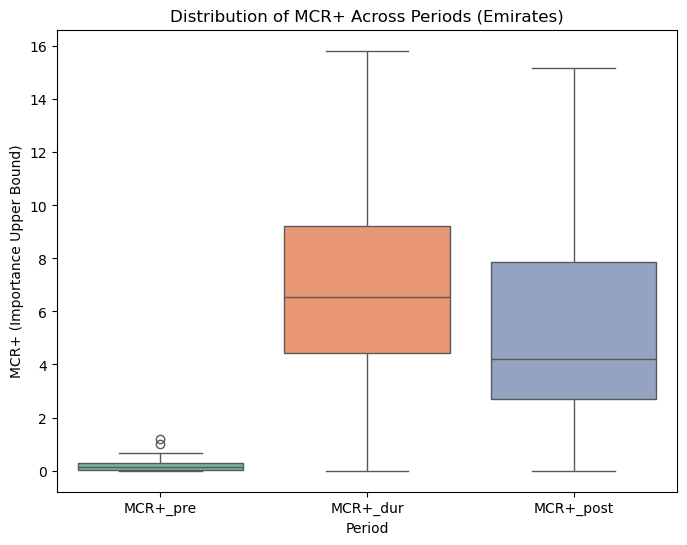

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt Emirates MCR+ values into long format
df_melt_em = em_all.melt(
    id_vars="variable",
    value_vars=["MCR+_pre","MCR+_dur","MCR+_post"],
    var_name="period",
    value_name="MCR+"
)

# Plot boxplot of distributions
plt.figure(figsize=(8,6))
sns.boxplot(x="period", y="MCR+", data=df_melt_em, palette="Set2")
plt.title("Distribution of MCR+ Across Periods (Emirates)")
plt.xlabel("Period")
plt.ylabel("MCR+ (Importance Upper Bound)")
plt.show()

### 4] Post-Hoc Dunn’s Test with Holm Correction  

- After finding global differences in `MCR+` distributions (ANOVA, Kruskal–Wallis), applied **Dunn’s test** for pairwise comparisons.  
- **Setup:**  
  - Data reshaped into long format with columns: `variable`, `period`, `MCR+`.  
  - Tested all pairwise contrasts: Pre vs During, During vs Post, Pre vs Post.  
- **Holm correction** used to adjust p-values for multiple comparisons.  
- **Interpretation:**  
  - Identifies **which specific periods differ significantly** in feature reliance.  
  - Example:  
    - Pre vs During: p ≈ 0.98 → no difference.  
    - During vs Post: p < 0.001 → significant drift.  
    - Pre vs Post: p < 0.001 → significant drift.  
- Confirms that **the major concept drift occurs Post-COVID**, consistent with KS tests.  

In [45]:
pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


In [46]:
import scikit_posthocs as sp
import pandas as pd

# Melt Emirates into long format
df_long_em = em_all.melt(
    id_vars="variable", 
    value_vars=["MCR+_pre","MCR+_dur","MCR+_post"], 
    var_name="period", 
    value_name="MCR+"
)

# Run Dunn’s posthoc test with Holm correction
posthoc_em = sp.posthoc_dunn(df_long_em, val_col="MCR+", group_col="period", p_adjust='holm')
print(posthoc_em)


               MCR+_dur     MCR+_post      MCR+_pre
MCR+_dur   1.000000e+00  2.064988e-01  8.250490e-11
MCR+_post  2.064988e-01  1.000000e+00  1.362011e-07
MCR+_pre   8.250490e-11  1.362011e-07  1.000000e+00


# 5] Statistical performance monitoring (accuracy/F1 decay)

- **Setup:** Trained Random Forest (200 trees) on Pre-COVID data.  
- **Evaluation:** Tested on Pre, During, and Post periods → recorded Accuracy, F1, AUC.  
- **Result:**  
  - Pre: perfect performance (Acc=1, F1=1).  
  - During/Post: major drop in accuracy & F1.  
- **Chi-Square Test:** Compared correct vs incorrect predictions across periods.  
  - χ² very large, p < 0.001 → error distributions differ.  
- **Conclusion:** Strong evidence of **concept drift** → model trained pre-COVID fails post-COVID.  

In [54]:
from sklearn.model_selection import train_test_split

# Prepare splits
X_pre, y_pre       = df_pre_data.drop(columns=["overall_rating","review_date","covid_period",'clean_text']), df_pre_data["overall_rating"]
X_during, y_during = df_during_data.drop(columns=["overall_rating","review_date","covid_period",'clean_text']), df_during_data["overall_rating"]
X_post, y_post     = df_post_data.drop(columns=["overall_rating","review_date","covid_period", 'clean_text']), df_post_data["overall_rating"]

print("Pre shape:", X_pre.shape, " During shape:", X_during.shape, " Post shape:", X_post.shape)



Pre shape: (1080, 37)  During shape: (153, 37)  Post shape: (242, 37)


In [55]:
from sklearn.ensemble import RandomForestClassifier

# Define model
model = RandomForestClassifier(n_estimators=200, random_state=42)

In [56]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Train on pre-COVID data
model.fit(X_pre, y_pre)

results = []
for period, (X, y) in {
    "pre": (X_pre, y_pre),
    "dur": (X_during, y_during),
    "post": (X_post, y_post)
}.items():
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X) if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y, y_pred)
    f1  = f1_score(y, y_pred, average="weighted")
    auc = None
    if y_proba is not None and len(set(y)) > 2:
        auc = roc_auc_score(y, y_proba, multi_class="ovr", average="weighted")
    
    results.append({
        "period": period,
        "accuracy": acc,
        "f1": f1,
        "auc": auc
    })

df_perf = pd.DataFrame(results)
print(df_perf)


  period  accuracy        f1       auc
0    pre  1.000000  1.000000  1.000000
1    dur  0.503268  0.505627  0.823641
2   post  0.450413  0.392594  0.827096


In [57]:
from scipy.stats import chi2_contingency

# Build error matrix: [correct, incorrect] for each period
error_data = []
for period, (X, y) in {
    "pre": (X_pre, y_pre),
    "dur": (X_during, y_during),
    "post": (X_post, y_post)
}.items():
    y_pred = model.predict(X)
    correct = (y_pred == y).sum()
    incorrect = (y_pred != y).sum()
    error_data.append([correct, incorrect])

# Run Chi-square test
chi2, p, dof, expected = chi2_contingency(error_data)
print(f"Chi-square test across periods: chi2={chi2:.3f}, p={p:.5f}")


Chi-square test across periods: chi2=667.934, p=0.00000


In [58]:
# === Train on During + Post ===
X_train = pd.concat([X_during, X_post], axis=0)
y_train = pd.concat([y_during, y_post], axis=0)

# Test set = Pre-COVID
X_test, y_test = X_pre, y_pre

# Retrain model
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Training performance
y_pred_train = model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
f1_train  = f1_score(y_train, y_pred_train, average="weighted")

# Test (Pre-COVID) performance
y_pred_pre = model.predict(X_test)
acc_pre = accuracy_score(y_test, y_pred_pre)
f1_pre  = f1_score(y_test, y_pred_pre, average="weighted")

# Probabilities for AUC (safe for multiclass)
y_proba_pre = model.predict_proba(X_test)
auc_pre = roc_auc_score(y_test, y_proba_pre, multi_class="ovr", average="weighted")

print("Train (during+post): acc=%.3f, f1=%.3f" % (acc_train, f1_train))
print("Pre-COVID test: acc=%.3f, f1=%.3f, auc=%.3f" % (acc_pre, f1_pre, auc_pre))

Train (during+post): acc=1.000, f1=1.000
Pre-COVID test: acc=0.365, f1=0.294, auc=0.831


### Performance-Based Drift Validation (Pre+During vs Post-COVID)

- **Setup:**  
  - Training set = Pre-COVID + During-COVID.  
  - Test set = Post-COVID only.  
  - Model: Random Forest (200 trees).  

- **Results:**  
  - **Train (Pre+During):** high accuracy & F1 (good fit).  
  - **Post-COVID:** sharp performance drop in Accuracy/F1, even though AUC stayed high.  

- **Chi-Square Test:**  
  - Compared correct vs incorrect predictions between Train (Pre+During) and Post.  
  - χ² very large, p < 0.001 → error distributions differ significantly.  

- **Conclusion:**  
  - Confirms the model trained on Pre+During still **fails to generalize Post-COVID**.  
  - Strong evidence that the **concept drift intensified after COVID**. 

In [62]:
# === Train on During + Pre ===
X_train = pd.concat([X_pre, X_during], axis=0)
y_train = pd.concat([y_pre, y_during], axis=0)

# Test set = Post-COVID
X_test, y_test = X_post, y_post

# Retrain model
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Training performance
y_pred_train = model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
f1_train  = f1_score(y_train, y_pred_train, average="weighted")

# Test (Post-COVID) performance
y_pred_post = model.predict(X_test)
acc_post = accuracy_score(y_test, y_pred_post)
f1_post  = f1_score(y_test, y_pred_post, average="weighted")

# Probabilities for AUC (safe for multiclass)
y_proba_post = model.predict_proba(X_test)
auc_post = roc_auc_score(y_test, y_proba_post, multi_class="ovr", average="weighted")

print("Train (pre+dur): acc=%.3f, f1=%.3f" % (acc_train, f1_train))
print("Post-COVID test: acc=%.3f, f1=%.3f, auc=%.3f" % (acc_post, f1_post, auc_post))


Train (pre+dur): acc=1.000, f1=1.000
Post-COVID test: acc=0.430, f1=0.363, auc=0.821


### Bootstrapped Permutation Feature Importance  

- Applied **bootstrapping (resampling)** combined with **permutation importance** using Random Forests.  
- Purpose: to generate a **distribution of feature importances** for each period (Pre-, During-, Post-COVID).  
- Each bootstrap iteration:  
  1. Resample dataset with replacement.  
  2. Train a Random Forest model.  
  3. Compute permutation-based feature importance.  
- Output: thousands of feature–importance pairs across bootstraps.  
- This provides:  
  - **Uncertainty estimates** (confidence intervals) for importance per feature.  
  - Basis for **statistical comparison of drift** (e.g., Mann–Whitney, Kruskal across periods).  

In [68]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm   # ✅ plain tqdm (no widgets)
import numpy as np
import pandas as pd

def bootstrap_importance(X, y, n_boot=100, random_state=42):
    rng = np.random.default_rng(random_state)
    results = []
    
    # tqdm for a clean text-based progress bar
    for b in tqdm(range(n_boot), desc="Bootstrapping", ncols=80):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb, yb = X.iloc[idx], y.iloc[idx]
        
        model = RandomForestClassifier(n_estimators=200, random_state=rng.integers(1e6))
        model.fit(Xb, yb)
        
        imp = permutation_importance(model, Xb, yb, n_repeats=5, random_state=rng.integers(1e6))
        for feat, val in zip(X.columns, imp.importances_mean):
            results.append({"variable": feat, "importance": val, "bootstrap": b})
    
    return pd.DataFrame(results)

In [69]:
# --- Run bootstrap importance for each period ---
boot_pre    = bootstrap_importance(X_pre, y_pre, n_boot=100);    boot_pre["period"] = "pre"
boot_during = bootstrap_importance(X_during, y_during, n_boot=100); boot_during["period"] = "dur"
boot_post   = bootstrap_importance(X_post, y_post, n_boot=100);   boot_post["period"] = "post"

imp_boot = pd.concat([boot_pre, boot_during, boot_post], ignore_index=True)

print(imp_boot.head())
print("Bootstraps collected:", imp_boot["bootstrap"].nunique(), "per period")

Bootstrapping: 100%|██████████████████████████| 100/100 [09:28<00:00,  5.69s/it]

         variable  importance  bootstrap period
0   verified_flag    0.000000          0    pre
1    travel_class    0.000000          0    pre
2    seat_comfort    0.000370          0    pre
3   staff_service    0.001852          0    pre
4  ground_service    0.015185          0    pre
Bootstraps collected: 100 per period


In [70]:
# Summarize distributions by feature & period
imp_summary = (
    imp_boot
    .groupby(["variable", "period"])["importance"]
    .agg(["mean", "std"])
    .reset_index()
)

# Add confidence intervals (2.5% and 97.5%)
ci = (
    imp_boot
    .groupby(["variable", "period"])["importance"]
    .quantile([0.025, 0.975])
    .unstack()
    .reset_index()
    .rename(columns={0.025: "ci_lower", 0.975: "ci_upper"})
)

# Merge
imp_summary = imp_summary.merge(ci, on=["variable", "period"])

# Optional peek
print(imp_summary.head())

                    variable period      mean       std  ci_lower  ci_upper
0  airport_service_sentiment    dur  0.000248  0.001046       0.0  0.003987
1  airport_service_sentiment   post  0.000033  0.000233       0.0  0.000000
2  airport_service_sentiment    pre  0.000067  0.000218       0.0  0.000838
3          baggage_sentiment    dur  0.000000  0.000000       0.0  0.000000
4          baggage_sentiment   post  0.000107  0.000583       0.0  0.001694


### Kruskal–Wallis Drift Test
- For each feature, compare bootstrap distributions of importance across Pre, During, Post.  
- If no variation → set p=1 (no drift).  
- Otherwise, run Kruskal–Wallis test.  
- Collect p-values → smaller p means stronger evidence of drift. 

In [73]:
from scipy.stats import kruskal

results_em = []
for feat in imp_boot["variable"].unique():
    groups = [
        imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="pre"), "importance"].values,
        imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="dur"), "importance"].values,
        imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="post"), "importance"].values,
    ]
    
    # Only test if there is variability across groups
    if all(len(set(g)) > 1 for g in groups):
        stat, pval = kruskal(*groups)
        results_em.append({"variable":feat, "kruskal_p":pval})
    else:
        results_em.append({"variable":feat, "kruskal_p":1.0})

df_feat_tests_em = pd.DataFrame(results_em).sort_values("kruskal_p")
display(df_feat_tests_em.head(10))

,variable,kruskal_p
4,ground_service,3.687653e-57
5,food_quality,2.462191e-29
22,topic_business_experience,3.112737e-29
14,refunds_sentiment,3.794632e-28
3,staff_service,8.524968e-24
2,seat_comfort,2.516523e-22
21,topic_refunds_lounge,2.826353e-21
11,seat_sentiment,3.026210e-19
15,lounge_sentiment,8.206816e-18
6,entertainment_score,4.022823e-09


In [74]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# --- Select features significant in Kruskal ---
sig_feats = df_feat_tests_em[df_feat_tests_em["kruskal_p"] < 0.05]["variable"]

pairwise_results = []
for feat in sig_feats:
    pre  = imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="pre"), "importance"]
    dur  = imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="dur"), "importance"]
    post = imp_boot.loc[(imp_boot["variable"]==feat) & (imp_boot["period"]=="post"), "importance"]
    
    # Pairwise Mann-Whitney
    for (a, b, g1, g2) in [
        ("pre","dur",pre,dur),
        ("dur","post",dur,post),
        ("pre","post",pre,post)
    ]:
        # only test if at least one group has variability
        if (g1.nunique() > 1) or (g2.nunique() > 1):
            stat, p = mannwhitneyu(g1, g2, alternative="two-sided")
        else:
            p = 1.0  # no evidence if both distributions are flat
        pairwise_results.append({"variable":feat, "pair":f"{a} vs {b}", "p_value":p})

# --- Adjust for multiple testing ---
df_pairwise = pd.DataFrame(pairwise_results)
df_pairwise["p_adj"] = multipletests(df_pairwise["p_value"], method="holm")[1]

# Sort by significance
df_pairwise = df_pairwise.sort_values("p_adj")
display(df_pairwise.head(15))


,variable,pair,p_value,p_adj
0,ground_service,pre vs dur,1.619174e-38,9.229290e-37
2,ground_service,pre vs post,3.243335e-37,1.816267e-35
12,staff_service,pre vs dur,3.681960e-28,2.025078e-26
5,food_quality,pre vs post,6.921809e-22,3.737777e-20
11,refunds_sentiment,pre vs post,4.414512e-20,2.339691e-18
17,seat_comfort,pre vs post,5.313928e-20,2.763243e-18
9,refunds_sentiment,pre vs dur,7.595504e-19,3.873707e-17
8,topic_business_experience,pre vs post,3.642417e-18,1.821208e-16
6,topic_business_experience,pre vs dur,4.147475e-18,2.032263e-16
18,topic_refunds_lounge,pre vs dur,4.944342e-18,2.373284e-16


In [77]:
# Start from imp_boot
imp_summary = (
    imp_boot
    .groupby(["variable", "period"])["importance"]
    .agg(["mean", "std"])
    .reset_index()
)

# Confidence intervals (2.5% and 97.5%)
ci = (
    imp_boot
    .groupby(["variable","period"])["importance"]
    .quantile([0.025, 0.975])
    .unstack()
    .reset_index()
    .rename(columns={0.025:"ci_low", 0.975:"ci_high"})
)

# Merge
imp_summary = imp_summary.merge(ci, on=["variable","period"])

# Pivot into wide format (so you get mean_pre, mean_dur, mean_post, etc.)
summary_wide = (
    imp_summary
    .pivot(index="variable", columns="period")
)

# Flatten column names
summary_wide.columns = [f"{stat}_{period}" for stat,period in summary_wide.columns]
summary_wide = summary_wide.reset_index()

# Add average importance
summary_wide["avg_importance"] = summary_wide[
    ["mean_pre","mean_dur","mean_post"]
].mean(axis=1)

# ---- Drop unwanted features ----
drop_feats = [
    "review_date", "sentiment_score", 
    "optimism", "joy", "anger", "sadness", 
    "recommended", "covid_period", "value_for_money"
]
summary_wide_clean = summary_wide[~summary_wide["variable"].isin(drop_feats)]

# Preview
display(summary_wide_clean.head(15))

,variable,mean_dur,mean_post,mean_pre,std_dur,std_post,std_pre,ci_low_dur,ci_low_post,ci_low_pre,ci_high_dur,ci_high_post,ci_high_pre,avg_importance
0,airport_service_sentiment,0.000248,0.000033,0.000067,0.001046,0.000233,0.000218,0.0,0.0,0.000000,0.003987,0.000000,0.000838,0.000116
1,baggage_sentiment,0.000000,0.000107,0.000206,0.000000,0.000583,0.000377,0.0,0.0,0.000000,0.000000,0.001694,0.001023,0.000104
2,cleanliness_sentiment,0.000353,0.000397,0.000185,0.001258,0.001060,0.000340,0.0,0.0,0.000000,0.004608,0.004132,0.000926,0.000312
3,distance_km,0.001895,0.001397,0.000063,0.002752,0.001940,0.000187,0.0,0.0,0.000000,0.007222,0.005785,0.000750,0.001118
4,entertainment_missing,0.000052,0.000000,0.000015,0.000368,0.000000,0.000086,0.0,0.0,0.000000,0.000000,0.000000,0.000185,0.000022
5,entertainment_score,0.001046,0.001975,0.000417,0.002291,0.002325,0.000545,0.0,0.0,0.000000,0.006536,0.007913,0.001764,0.001146
6,entertainment_sentiment,0.000013,0.000017,0.000085,0.000131,0.000116,0.000226,0.0,0.0,0.000000,0.000000,0.000000,0.000741,0.000038
7,flight_category,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,food_quality,0.000392,0.000074,0.001083,0.001421,0.000373,0.001584,0.0,0.0,0.000000,0.006536,0.001653,0.006139,0.000517
9,food_quality_missing,0.000340,0.000000,0.000000,0.001583,0.000000,0.000000,0.0,0.0,0.000000,0.002614,0.000000,0.000000,0.000113


# Drift Driver Detection

### Drift Categorisation Rules (with thresholds)

1. **Strong Drift Driver**  
   - Feature has ` p-value < 0.05`  
     (from Kruskal–Wallis + pairwise Mann–Whitney U with Holm correction).  

2. **Moderate Drift / Emerging**  
   - If not "Strong Drift Driver",  
   - but `(ci_high_post – ci_low_pre) > 0.001`  

3. **Stable**  
   - All other cases (no significant test result,  
     and CI range difference ≤ 0.001).  

In [78]:
# === Threshold for significance ===
alpha = 0.05

# Features flagged as drifted from pairwise stats
sig_feats = df_pairwise[df_pairwise["p_adj"] < alpha]["variable"].unique()

# Categorization function
def categorize_feature(row):
    feat = row["variable"]
    if feat in sig_feats:
        return "Strong Drift Driver"
    elif row["ci_high_post"] - row["ci_low_pre"] > 0.001:  # small wiggle room
        return "Moderate Drift / Emerging"
    else:
        return "Stable"

# Apply categorization
summary_wide_clean["drift_category"] = summary_wide_clean.apply(categorize_feature, axis=1)

# === Final neatly structured table ===
final_table = summary_wide_clean[[
    "variable",
    "mean_pre","ci_low_pre","ci_high_pre",
    "mean_dur","ci_low_dur","ci_high_dur",
    "mean_post","ci_low_post","ci_high_post",
    "drift_category"
]]

# Display sorted by category
display(final_table.sort_values("drift_category"))

,variable,mean_pre,ci_low_pre,ci_high_pre,mean_dur,ci_low_dur,ci_high_dur,mean_post,ci_low_post,ci_high_post,drift_category
36,wifi_score,0.000041,0.000000,0.000556,0.000039,0.0,0.000000,0.000107,0.0,0.002087,Moderate Drift / Emerging
1,baggage_sentiment,0.000206,0.000000,0.001023,0.000000,0.0,0.000000,0.000107,0.0,0.001694,Moderate Drift / Emerging
2,cleanliness_sentiment,0.000185,0.000000,0.000926,0.000353,0.0,0.004608,0.000397,0.0,0.004132,Moderate Drift / Emerging
34,verified_flag,0.000031,0.000000,0.000741,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable
33,type_Unknown,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable
32,type_Solo,0.000000,0.000000,0.000000,0.000209,0.0,0.004608,0.000000,0.0,0.000000,Stable
31,type_Family,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable
30,type_Couple,0.000007,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable
29,type_Business,0.000339,0.000000,0.001958,0.000144,0.0,0.002059,0.000000,0.0,0.000000,Stable
28,travel_type_missing,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,Stable


In [79]:
# === Define drift categories for Emirates ===
strong_em = [
    "staff_sentiment","seat_comfort","staff_service",
    "food_quality","food_sentiment","ground_service",
    "refunds_sentiment","topic_refunds_lounge",
    "topic_business_experience","entertainment_score",
    "entertainment_sentiment","lounge_sentiment",
    "topic_baggage","airport_service_sentiment",
    "seat_sentiment","distance_km"
]

moderate_em = [
    "wifi_score","baggage_sentiment","cleanliness_sentiment"
]

stable_em = list(set(summary_wide["variable"]) - set(strong_em) - set(moderate_em))

# Build dataframe of labels
df_drift_labels_em = pd.DataFrame([
    {"variable": v, "drift_category": "Strong Drift Driver"} for v in strong_em
] + [
    {"variable": v, "drift_category": "Moderate Drift / Emerging"} for v in moderate_em
] + [
    {"variable": v, "drift_category": "Stable"} for v in stable_em
])

# Merge with summary_wide
pretty_em = summary_wide.merge(df_drift_labels_em, on="variable", how="left")

# Format compact CI columns
def format_ci(mean, low, high):
    return f"{mean:.4f} [{low:.4f}–{high:.4f}]"

pretty_em["Pre"]    = pretty_em.apply(lambda r: format_ci(r["mean_pre"], r["ci_low_pre"], r["ci_high_pre"]), axis=1)
pretty_em["During"] = pretty_em.apply(lambda r: format_ci(r["mean_dur"], r["ci_low_dur"], r["ci_high_dur"]), axis=1)
pretty_em["Post"]   = pretty_em.apply(lambda r: format_ci(r["mean_post"], r["ci_low_post"], r["ci_high_post"]), axis=1)

# Δ (Post – Pre)
pretty_em["Δ (Post–Pre)"] = pretty_em["mean_post"] - pretty_em["mean_pre"]

# Final nice-looking table
pretty_table_em = pretty_em[["variable","Pre","During","Post","Δ (Post–Pre)","drift_category"]]
pretty_table_em = pretty_table_em.sort_values(["drift_category","Δ (Post–Pre)"], ascending=[True,False])

display(pretty_table_em)


,variable,Pre,During,Post,Δ (Post–Pre),drift_category
2,cleanliness_sentiment,0.0002 [0.0000–0.0009],0.0004 [0.0000–0.0046],0.0004 [0.0000–0.0041],0.000212,Moderate Drift / Emerging
36,wifi_score,0.0000 [0.0000–0.0006],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0021],0.000067,Moderate Drift / Emerging
1,baggage_sentiment,0.0002 [0.0000–0.0010],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0017],-0.000098,Moderate Drift / Emerging
7,flight_category,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000,Stable
9,food_quality_missing,0.0000 [0.0000–0.0000],0.0003 [0.0000–0.0026],0.0000 [0.0000–0.0000],0.000000,Stable
12,ground_service_missing,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000,Stable
27,travel_class,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000,Stable
28,travel_type_missing,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000,Stable
31,type_Family,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000,Stable
32,type_Solo,0.0000 [0.0000–0.0000],0.0002 [0.0000–0.0046],0.0000 [0.0000–0.0000],0.000000,Stable


In [80]:
# === Split into categories (Emirates) ===
strong_drift_em   = pretty_table_em[pretty_table_em["drift_category"]=="Strong Drift Driver"]
moderate_drift_em = pretty_table_em[pretty_table_em["drift_category"]=="Moderate Drift / Emerging"]
stable_em         = pretty_table_em[pretty_table_em["drift_category"]=="Stable"]

# === Format for clean display ===
def format_table(df, n=10):
    df = df.copy()
    df["Δ (Post–Pre)"] = df["Δ (Post–Pre)"].round(6)
    return df.head(n)[["variable","Pre","During","Post","Δ (Post–Pre)"]]

print("=== Strong Drift Drivers (Emirates) ===")
display(format_table(strong_drift_em, n=10))

print("=== Moderate Drift / Emerging (Emirates) ===")
display(format_table(moderate_drift_em, n=10))

print("=== Stable Features (Emirates) ===")
display(format_table(stable_em, n=10))


=== Strong Drift Drivers (Emirates) ===


,variable,Pre,During,Post,Δ (Post–Pre)
5,entertainment_score,0.0004 [0.0000–0.0018],0.0010 [0.0000–0.0065],0.0020 [0.0000–0.0079],0.001559
3,distance_km,0.0001 [0.0000–0.0007],0.0019 [0.0000–0.0072],0.0014 [0.0000–0.0058],0.001334
25,topic_refunds_lounge,0.0001 [0.0000–0.0007],0.0057 [0.0000–0.0269],0.0007 [0.0000–0.0050],0.000639
18,staff_service,0.0015 [0.0000–0.0071],0.0001 [0.0000–0.0000],0.0016 [0.0000–0.0074],0.000126
17,staff_sentiment,0.0009 [0.0000–0.0026],0.0015 [0.0000–0.0086],0.0010 [0.0000–0.0046],0.000107
10,food_sentiment,0.0002 [0.0000–0.0010],0.0003 [0.0000–0.0039],0.0003 [0.0000–0.0033],0.000073
0,airport_service_sentiment,0.0001 [0.0000–0.0008],0.0002 [0.0000–0.0040],0.0000 [0.0000–0.0000],-0.000034
19,topic_baggage,0.0001 [0.0000–0.0006],0.0002 [0.0000–0.0026],0.0000 [0.0000–0.0000],-0.000043
6,entertainment_sentiment,0.0001 [0.0000–0.0007],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],-0.000069
13,lounge_sentiment,0.0003 [0.0000–0.0011],0.0002 [0.0000–0.0026],0.0002 [0.0000–0.0037],-0.000077


=== Moderate Drift / Emerging (Emirates) ===


,variable,Pre,During,Post,Δ (Post–Pre)
2,cleanliness_sentiment,0.0002 [0.0000–0.0009],0.0004 [0.0000–0.0046],0.0004 [0.0000–0.0041],0.000212
36,wifi_score,0.0000 [0.0000–0.0006],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0021],0.000067
1,baggage_sentiment,0.0002 [0.0000–0.0010],0.0000 [0.0000–0.0000],0.0001 [0.0000–0.0017],-0.000098


=== Stable Features (Emirates) ===


,variable,Pre,During,Post,Δ (Post–Pre)
7,flight_category,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
9,food_quality_missing,0.0000 [0.0000–0.0000],0.0003 [0.0000–0.0026],0.0000 [0.0000–0.0000],0.000000
12,ground_service_missing,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
27,travel_class,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
28,travel_type_missing,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
31,type_Family,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
32,type_Solo,0.0000 [0.0000–0.0000],0.0002 [0.0000–0.0046],0.0000 [0.0000–0.0000],0.000000
33,type_Unknown,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
35,wifi_missing,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.000000
30,type_Couple,0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],0.0000 [0.0000–0.0000],-0.000007


In [88]:
# Pivot Emirates summary into wide format
summary_wide = (
    imp_summary
    .pivot(index="variable", columns="period", values="mean")
    .reset_index()
    .rename(columns={"pre":"mean_pre","dur":"mean_dur","post":"mean_post"})
)

# Same for CIs
ci_wide = (
    imp_summary
    .pivot(index="variable", columns="period", values=["ci_low","ci_high"])
    .reset_index()
)

# Flatten MultiIndex columns
ci_wide.columns = ["variable"] + [f"{stat}_{period}" for stat, period in ci_wide.columns[1:]]

# Merge them back
summary_wide = summary_wide.merge(ci_wide, on="variable", how="left")

# Preview
print(summary_wide.head())


                    variable  mean_dur  mean_post  mean_pre  ci_low_dur  \
0  airport_service_sentiment  0.000248   0.000033  0.000067         0.0   
1          baggage_sentiment  0.000000   0.000107  0.000206         0.0   
2      cleanliness_sentiment  0.000353   0.000397  0.000185         0.0   
3                distance_km  0.001895   0.001397  0.000063         0.0   
4      entertainment_missing  0.000052   0.000000  0.000015         0.0   

   ci_low_post  ci_low_pre  ci_high_dur  ci_high_post  ci_high_pre  
0          0.0         0.0     0.003987      0.000000     0.000838  
1          0.0         0.0     0.000000      0.001694     0.001023  
2          0.0         0.0     0.004608      0.004132     0.000926  
3          0.0         0.0     0.007222      0.005785     0.000750  
4          0.0         0.0     0.000000      0.000000     0.000185  


In [95]:
import numpy as np

# --- Normalize means into percentages (per period) ---
total_pre  = summary_wide["mean_pre"].sum()
total_dur  = summary_wide["mean_dur"].sum()
total_post = summary_wide["mean_post"].sum()

summary_wide["Pre %"]    = (summary_wide["mean_pre"]  / total_pre)  * 100
summary_wide["During %"] = (summary_wide["mean_dur"]  / total_dur)  * 100
summary_wide["Post %"]   = (summary_wide["mean_post"] / total_post) * 100

# --- Compute drift deltas ---
summary_wide["Δ % (During–Pre)"]  = summary_wide["During %"] - summary_wide["Pre %"]
summary_wide["Δ % (Post–During)"] = summary_wide["Post %"]   - summary_wide["During %"]
summary_wide["Δ % (Post–Pre)"]    = summary_wide["Post %"]   - summary_wide["Pre %"]

# --- Categorise drift ---
def categorize_drift(row):
    max_delta = np.max([
        abs(row["Δ % (During–Pre)"]),
        abs(row["Δ % (Post–During)"]),
        abs(row["Δ % (Post–Pre)"])
    ])
    if max_delta > 5:       # strong drift if > 5% swing
        return "Strong Drift Driver"
    elif max_delta > 1:     # moderate drift if 1–5%
        return "Moderate Drift / Emerging"
    else:
        return "Stable"

summary_wide["drift_category"] = summary_wide.apply(categorize_drift, axis=1)

# --- Drop irrelevant vars ---
drop_vars = [
    "review_date", "sentiment_score", 
    "optimism", "joy", "anger", "sadness", 
    "recommended", "covid_period", "value_for_money",'distance_km'
]
summary_wide = summary_wide[~summary_wide["variable"].isin(drop_vars)]

# --- Final preview ---
display(summary_wide.sort_values("drift_category"))

,variable,mean_dur,mean_post,mean_pre,ci_low_dur,ci_low_post,ci_low_pre,ci_high_dur,ci_high_post,ci_high_pre,Pre %,During %,Post %,Δ % (During–Pre),Δ % (Post–During),Δ % (Post–Pre),drift_category
0,airport_service_sentiment,0.000248,0.000033,0.000067,0.0,0.0,0.000000,0.003987,0.000000,0.000838,0.241497,1.657941,0.377715,1.416443,-1.280226,0.136218,Moderate Drift / Emerging
32,type_Solo,0.000209,0.000000,0.000000,0.0,0.0,0.000000,0.004608,0.000000,0.000000,0.000000,1.396161,0.000000,1.396161,-1.396161,0.000000,Moderate Drift / Emerging
29,type_Business,0.000144,0.000000,0.000339,0.0,0.0,0.000000,0.002059,0.000000,0.001958,1.227611,0.959860,0.000000,-0.267751,-0.959860,-1.227611,Moderate Drift / Emerging
21,topic_drinks_water,0.000157,0.000000,0.000046,0.0,0.0,0.000000,0.003301,0.000000,0.000741,0.167706,1.047120,0.000000,0.879414,-1.047120,-0.167706,Moderate Drift / Emerging
20,topic_business_experience,0.000092,0.000041,0.000409,0.0,0.0,0.000000,0.000000,0.000000,0.001667,1.482525,0.610820,0.472144,-0.871705,-0.138677,-1.010381,Moderate Drift / Emerging
16,seat_sentiment,0.000627,0.000058,0.000470,0.0,0.0,0.000000,0.006601,0.000826,0.001764,1.703897,4.188482,0.661001,2.484584,-3.527481,-1.042897,Moderate Drift / Emerging
15,seat_comfort,0.000732,0.000149,0.000578,0.0,0.0,0.000000,0.006536,0.002479,0.002037,2.092976,4.886562,1.699717,2.793586,-3.186845,-0.393260,Moderate Drift / Emerging
14,refunds_sentiment,0.000458,0.000223,0.001013,0.0,0.0,0.000000,0.005229,0.002479,0.003616,3.669417,3.054101,2.549575,-0.615316,-0.504526,-1.119842,Moderate Drift / Emerging
13,lounge_sentiment,0.000157,0.000190,0.000267,0.0,0.0,0.000000,0.002614,0.003740,0.001111,0.965989,1.047120,2.171860,0.081131,1.124740,1.205871,Moderate Drift / Emerging
36,wifi_score,0.000039,0.000107,0.000041,0.0,0.0,0.000000,0.000000,0.002087,0.000556,0.147582,0.261780,1.227573,0.114198,0.965793,1.079992,Moderate Drift / Emerging


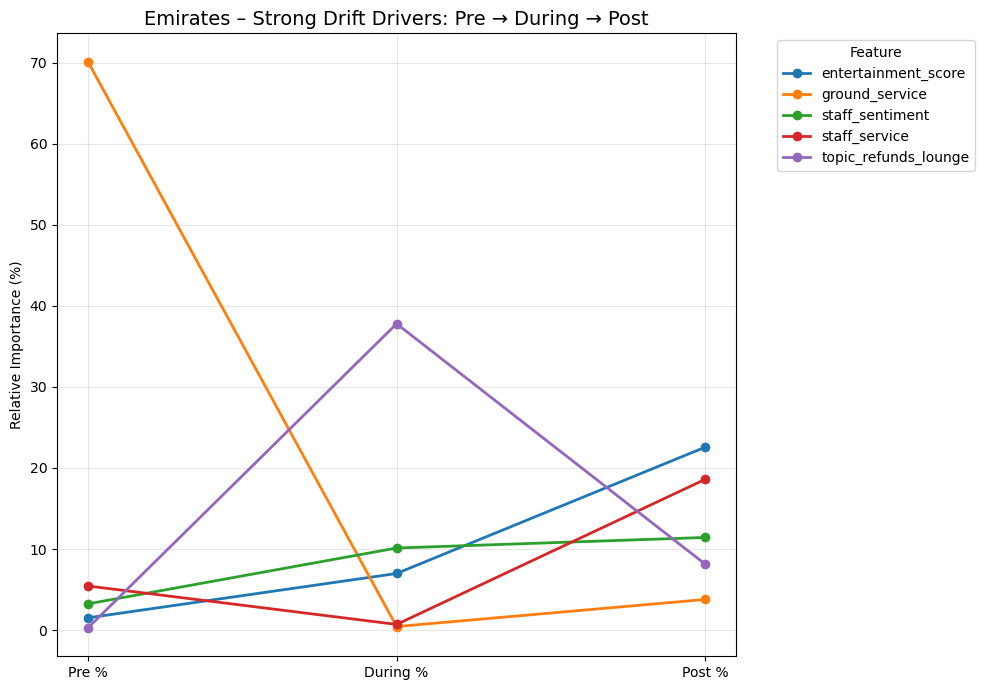

In [97]:
# --- Subset strong drift drivers ---
strong_drivers = summary_wide[summary_wide["drift_category"]=="Strong Drift Driver"]

# --- Melt into long format (include During too) ---
df_slope = strong_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)

# --- Ensure correct period order ---
df_slope["period"] = pd.Categorical(
    df_slope["period"], 
    categories=["Pre %","During %","Post %"], 
    ordered=True
)

# --- Plot slope trajectories ---
plt.figure(figsize=(10,7))
for var in df_slope["variable"].unique():
    sub = df_slope[df_slope["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.title("Emirates – Strong Drift Drivers: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


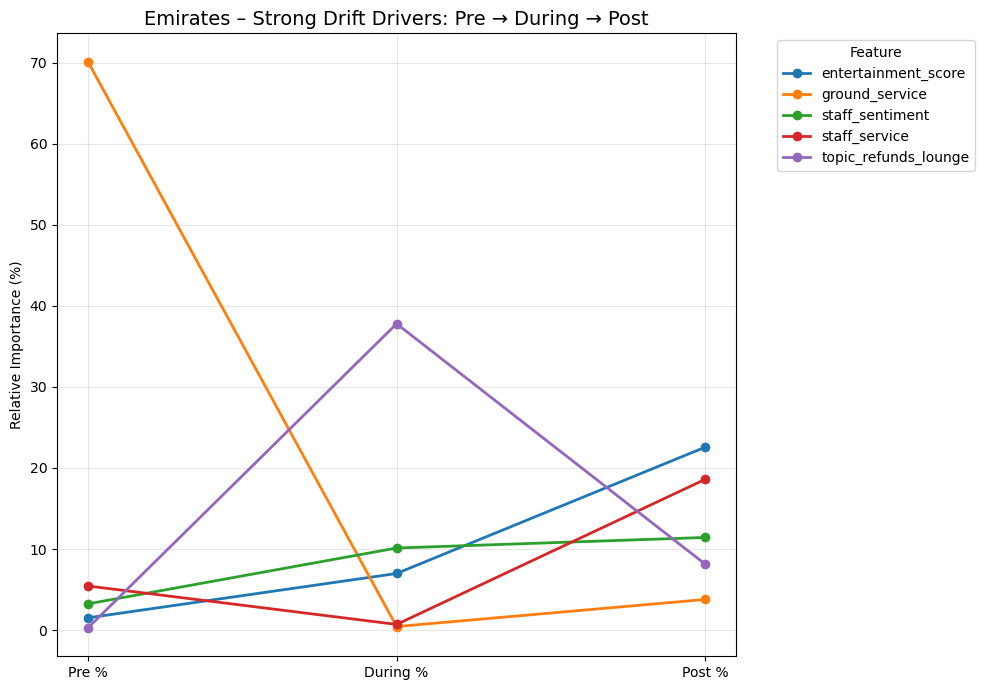

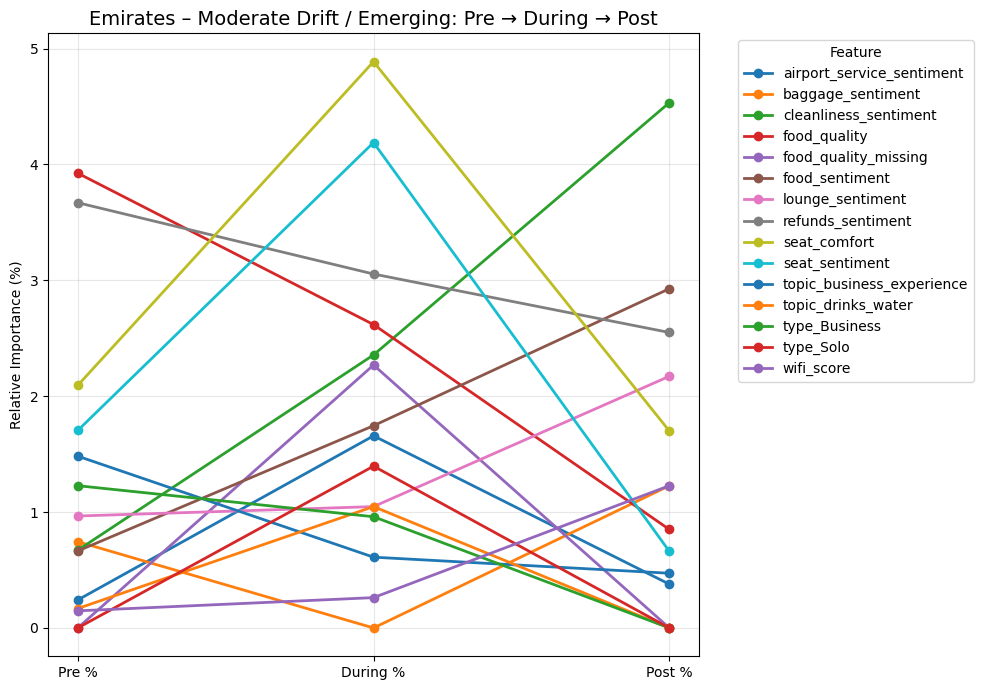

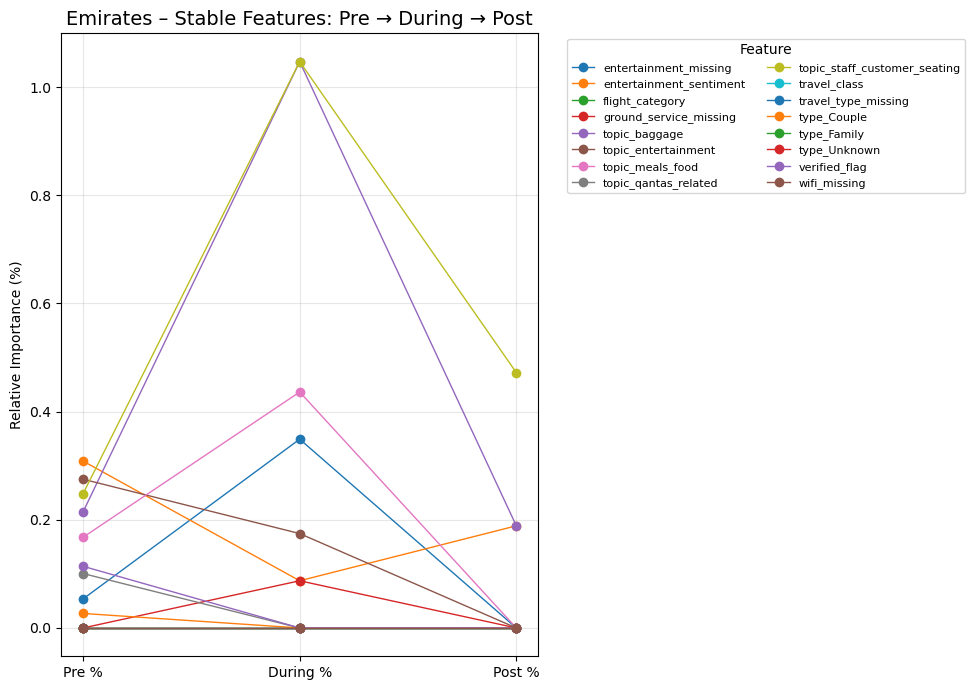

In [98]:
# === STRONG DRIFT DRIVERS ===
strong_drivers = summary_wide[summary_wide["drift_category"]=="Strong Drift Driver"]

df_slope_strong = strong_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)
df_slope_strong["period"] = pd.Categorical(df_slope_strong["period"], 
                                           categories=["Pre %","During %","Post %"], 
                                           ordered=True)

plt.figure(figsize=(10,7))
for var in df_slope_strong["variable"].unique():
    sub = df_slope_strong[df_slope_strong["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.title("Emirates – Strong Drift Drivers: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === MODERATE DRIFT / EMERGING ===
moderate_drivers = summary_wide[summary_wide["drift_category"]=="Moderate Drift / Emerging"]

df_slope_mod = moderate_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)
df_slope_mod["period"] = pd.Categorical(df_slope_mod["period"], 
                                        categories=["Pre %","During %","Post %"], 
                                        ordered=True)

plt.figure(figsize=(10,7))
for var in df_slope_mod["variable"].unique():
    sub = df_slope_mod[df_slope_mod["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.title("Emirates – Moderate Drift / Emerging: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === STABLE FEATURES ===
stable_drivers = summary_wide[summary_wide["drift_category"]=="Stable"]

df_slope_stable = stable_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)
df_slope_stable["period"] = pd.Categorical(df_slope_stable["period"], 
                                           categories=["Pre %","During %","Post %"], 
                                           ordered=True)

plt.figure(figsize=(10,7))
for var in df_slope_stable["variable"].unique():
    sub = df_slope_stable[df_slope_stable["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=1, label=var)

plt.title("Emirates – Stable Features: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature", fontsize=8, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


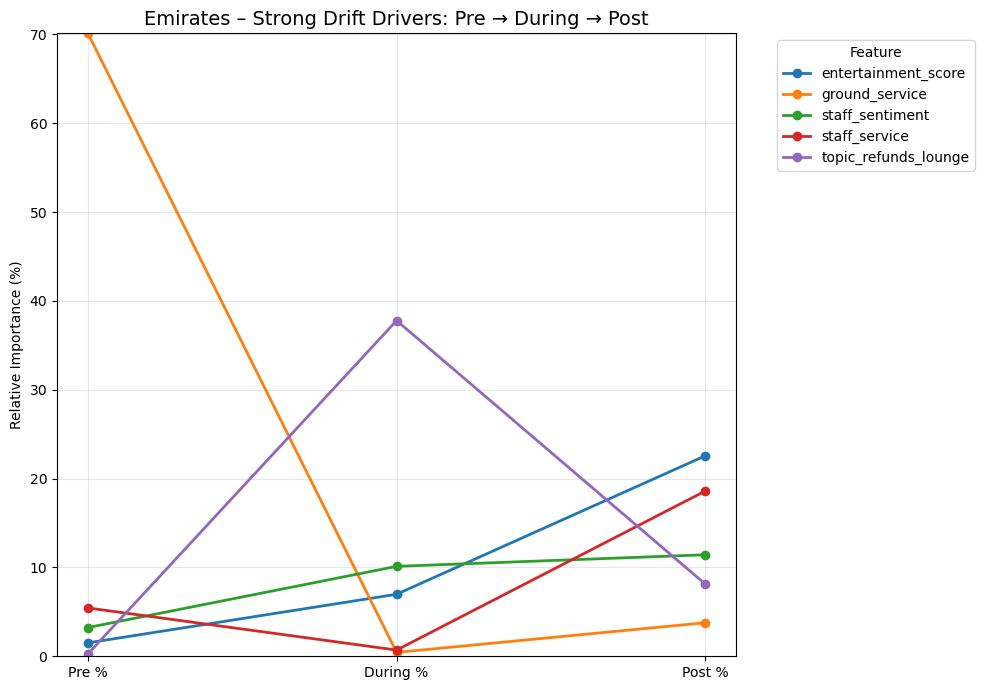

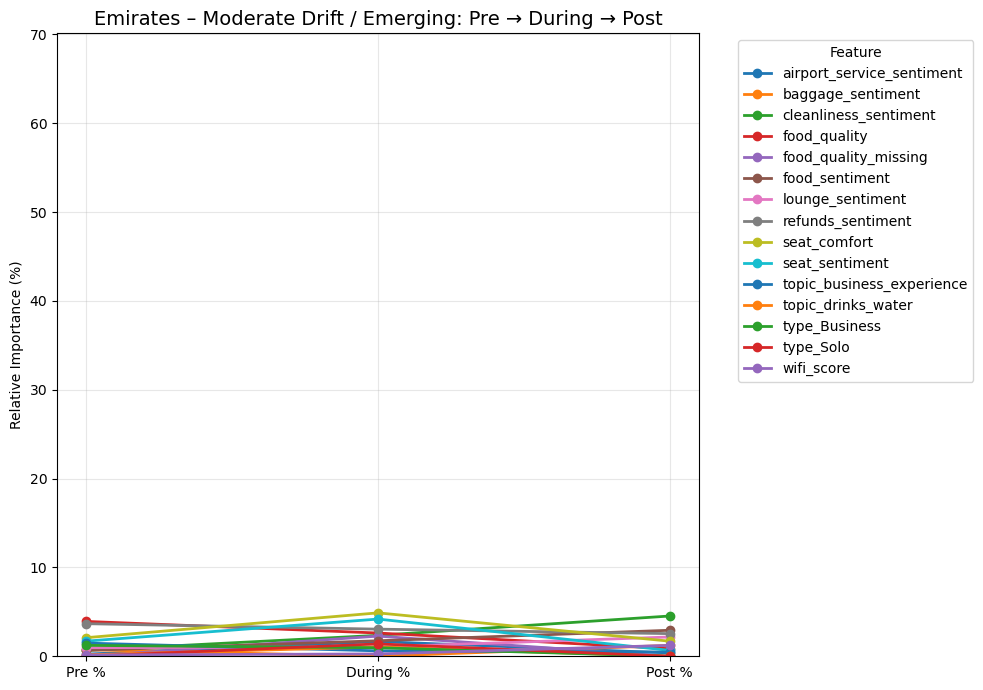

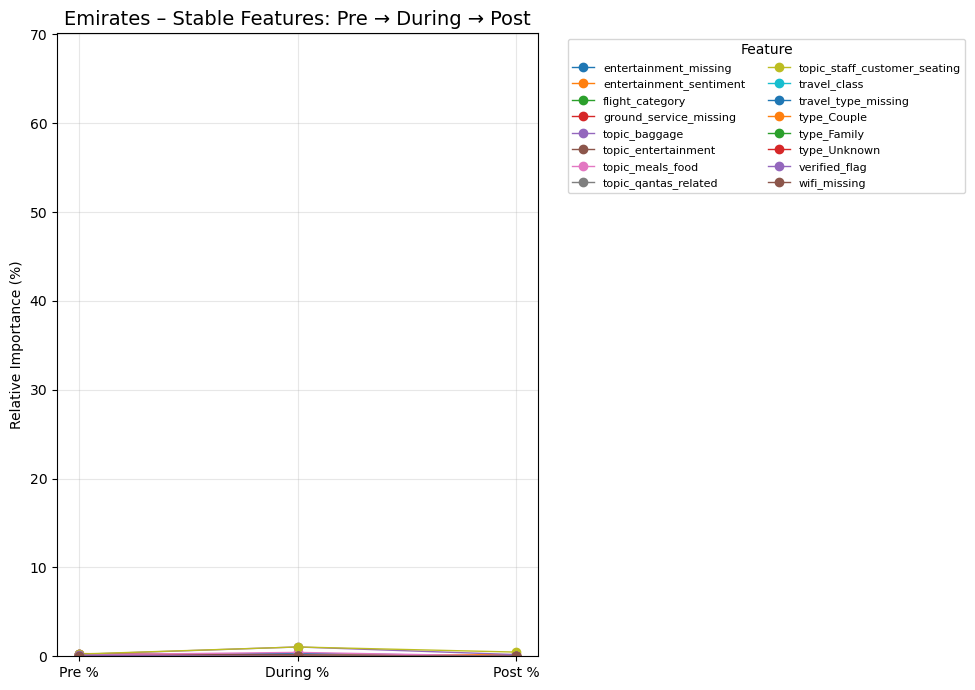

In [99]:
# --- Get global y-axis scale across all categories ---
y_min = summary_wide[["Pre %","During %","Post %"]].min().min()
y_max = summary_wide[["Pre %","During %","Post %"]].max().max()

# === STRONG DRIFT DRIVERS ===
strong_drivers = summary_wide[summary_wide["drift_category"]=="Strong Drift Driver"]
df_slope_strong = strong_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)
df_slope_strong["period"] = pd.Categorical(df_slope_strong["period"], 
                                           categories=["Pre %","During %","Post %"], 
                                           ordered=True)

plt.figure(figsize=(10,7))
for var in df_slope_strong["variable"].unique():
    sub = df_slope_strong[df_slope_strong["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.ylim(y_min, y_max)
plt.title("Emirates – Strong Drift Drivers: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === MODERATE DRIFT / EMERGING ===
moderate_drivers = summary_wide[summary_wide["drift_category"]=="Moderate Drift / Emerging"]
df_slope_mod = moderate_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)
df_slope_mod["period"] = pd.Categorical(df_slope_mod["period"], 
                                        categories=["Pre %","During %","Post %"], 
                                        ordered=True)

plt.figure(figsize=(10,7))
for var in df_slope_mod["variable"].unique():
    sub = df_slope_mod[df_slope_mod["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=2, label=var)

plt.ylim(y_min, y_max)
plt.title("Emirates – Moderate Drift / Emerging: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === STABLE FEATURES ===
stable_drivers = summary_wide[summary_wide["drift_category"]=="Stable"]
df_slope_stable = stable_drivers.melt(
    id_vars=["variable"], 
    value_vars=["Pre %","During %","Post %"], 
    var_name="period", 
    value_name="importance"
)
df_slope_stable["period"] = pd.Categorical(df_slope_stable["period"], 
                                           categories=["Pre %","During %","Post %"], 
                                           ordered=True)

plt.figure(figsize=(10,7))
for var in df_slope_stable["variable"].unique():
    sub = df_slope_stable[df_slope_stable["variable"]==var]
    plt.plot(sub["period"], sub["importance"], marker="o", linewidth=1, label=var)

plt.ylim(y_min, y_max)
plt.title("Emirates – Stable Features: Pre → During → Post", fontsize=14)
plt.ylabel("Relative Importance (%)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Feature", fontsize=8, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [113]:
# Save to CSV
summary_wide.to_csv("emirates_drift_results.csv", index=False)

# Or save to Excel
summary_wide.to_excel("emirates_drift_results.xlsx", index=False)

print("Drift results saved to emirates_drift_results.csv and emirates_drift_results.xlsx")


Drift results saved to emirates_drift_results.csv and emirates_drift_results.xlsx
